### Imports

In [1]:
from tqdm import tqdm
import random
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_mtsim
sys.path.append("C:/Users/WilliamFetzner/Documents/Trading/")
from gym_mtsim_forked.gym_mtsim.data import FOREX_DATA_PATH_TRAIN, FOREX_DATA_PATH_TEST, FOREX_DATA_PATH
from gym_mtsim import OrderType, Timeframe, MtEnv, MtSimulator
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, STATUS_FAIL
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
import time
import torch
import pickle

c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment forex-hedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment forex-unhedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment stocks-hedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment stocks-unhedge-v0 alr

# Parameters

In [2]:
# import pickle
# import time
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials


# def objective(x):
#     return {
#         'loss': x ** 2,
#         'status': STATUS_OK,
#         # -- store other results like this
#         'eval_time': time.time(),
#         'other_stuff': {'type': None, 'value': x},
#         # -- attachments are handled differently
#         'attachments':
#             {'time_module': pickle.dumps(time.time)}
#         }
# trials = Trials()
# best = fmin(objective,
#             space=hp.uniform('x', -10, 10),
#             algo=tpe.suggest,
#             max_evals=100,
#             trials=trials)

# print(best)

In [3]:
# trials.results

In [2]:

# unpack the pickle file and load the data that is in symbols_forex.pkl
with open('C:/Users/WilliamFetzner/Documents/Trading/gym_mtsim_forked/gym_mtsim/data/symbols_forex.pkl', 'rb') as f:
    symbols = pickle.load(f)
# convert symbols to a pd.dataframe
# symbols[1]['EURUSD']
split = int(len(symbols[1]['EURUSD']) * 0.80)
validation_split = int(len(symbols[1]['EURUSD']) * 0.90)

In [3]:
# get the 2 weeks of the symbols[1]['EURUSD'] dataframe by first finding the max date
# then subtracting 14 days from that date
symbols[1]['EURUSD'].index = pd.to_datetime(symbols[1]['EURUSD'].index)
max_date = symbols[1]['EURUSD'].index.max()

In [4]:
# find the previous friday before max_date
# what is the day of the week of the max_date
max_day_of_week = max_date.dayofweek
# subtract the day of the week from the max_date to get the previous friday
max_friday = max_date - pd.DateOffset(days=max_day_of_week+2)
two_weeks = max_friday - pd.DateOffset(days=14)
one_week = max_friday - pd.DateOffset(days=7)

In [5]:
training_index_slice = symbols[1]['EURUSD'].loc[:two_weeks, :].index
validation_index_slice = symbols[1]['EURUSD'].loc[two_weeks:one_week, :].index
testing_index_slice = symbols[1]['EURUSD'].loc[one_week:max_friday, :].index

In [17]:
validation_index_slice

DatetimeIndex(['2024-04-01 00:00:00+00:00', '2024-04-01 01:00:00+00:00',
               '2024-04-01 02:00:00+00:00', '2024-04-01 03:00:00+00:00',
               '2024-04-01 04:00:00+00:00', '2024-04-01 05:00:00+00:00',
               '2024-04-01 06:00:00+00:00', '2024-04-01 07:00:00+00:00',
               '2024-04-01 08:00:00+00:00', '2024-04-01 09:00:00+00:00',
               ...
               '2024-04-05 14:00:00+00:00', '2024-04-05 15:00:00+00:00',
               '2024-04-05 16:00:00+00:00', '2024-04-05 17:00:00+00:00',
               '2024-04-05 18:00:00+00:00', '2024-04-05 19:00:00+00:00',
               '2024-04-05 20:00:00+00:00', '2024-04-05 21:00:00+00:00',
               '2024-04-05 22:00:00+00:00', '2024-04-05 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Time', length=120, freq=None)

In [18]:
testing_index_slice

DatetimeIndex(['2024-04-08 00:00:00+00:00', '2024-04-08 01:00:00+00:00',
               '2024-04-08 02:00:00+00:00', '2024-04-08 03:00:00+00:00',
               '2024-04-08 04:00:00+00:00', '2024-04-08 05:00:00+00:00',
               '2024-04-08 06:00:00+00:00', '2024-04-08 07:00:00+00:00',
               '2024-04-08 08:00:00+00:00', '2024-04-08 09:00:00+00:00',
               ...
               '2024-04-12 14:00:00+00:00', '2024-04-12 15:00:00+00:00',
               '2024-04-12 16:00:00+00:00', '2024-04-12 17:00:00+00:00',
               '2024-04-12 18:00:00+00:00', '2024-04-12 19:00:00+00:00',
               '2024-04-12 20:00:00+00:00', '2024-04-12 21:00:00+00:00',
               '2024-04-12 22:00:00+00:00', '2024-04-12 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Time', length=120, freq=None)

### Create Env

In [6]:
sim_train = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

In [19]:
env_train = MtEnv(
    original_simulator=sim_train,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=list(training_index_slice),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [8]:
sim_validation = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_validation = MtEnv(
    original_simulator=sim_validation,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=list(validation_index_slice),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [20]:
sim_testing = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_testing = MtEnv(
    original_simulator=sim_testing,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=list(testing_index_slice),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

### Define Functions

In [81]:
def print_stats(reward_over_episodes, printing_name):
    """  Print Reward  """

    avg_rewards = np.mean(reward_over_episodes)
    min_rewards = np.min(reward_over_episodes)
    max_rewards = np.max(reward_over_episodes)

    print (f'Min. {printing_name}          : {min_rewards:>10.3f}')
    print (f'Avg. {printing_name}          : {avg_rewards:>10.3f}')
    print (f'Max. {printing_name}          : {max_rewards:>10.3f}')

    return min_rewards, avg_rewards, max_rewards

def my_profit_calculation(env_orders, stop_loss):
        # env_orders = env_testing.render()['orders']
        # stop_loss = 0.001

        # normalize the Volume with to have a mean of 1
        mean_value = env_orders['Volume'].mean()

        # Normalize the column to have a mean of 1
        env_orders.loc[:, 'Volume_normalized'] = round((env_orders['Volume'] / mean_value), 2)
        # add a column for when the difference between the Entry Price and the Exit Price is greater than stop_loss
        env_orders.loc[:, 'stoploss_hit'] = np.where((env_orders['Type'].str.strip() == 'Buy') &
                                                        ((env_orders['Entry Price'] - env_orders['Exit Price']) > stop_loss),
                                                        1, np.where((env_orders['Type'].str.strip() == 'Sell') &
                                                                        ((env_orders['Exit Price'] - env_orders['Entry Price']) > stop_loss),
                                                                        1, 0))
        env_orders.loc[:, 'Exit Price'] = np.where((env_orders['Type'].str.strip() == 'Buy') & (env_orders['stoploss_hit'] == 1),
                                                        env_orders['Entry Price'] - stop_loss,
                                                        np.where((env_orders['Type'].str.strip() == 'Sell') & (env_orders['stoploss_hit'] == 1),
                                                                env_orders['Entry Price'] + stop_loss, env_orders['Exit Price']))
        env_orders.loc[:, 'Profit'] = np.where((env_orders['Type'].str.strip() == 'Buy'),
                                                        ((env_orders['Exit Price'] - (env_orders['Fee']/2)) - 
                                                        (env_orders['Entry Price'] + (env_orders['Fee']/2)))
                                                                * 100_000 * env_orders['Volume_normalized'], 
                                                        np.where((env_orders['Type'].str.strip() == 'Sell'),
                                                                ((env_orders['Entry Price'] - (env_orders['Fee']/2)) - 
                                                                (env_orders['Exit Price'] + (env_orders['Fee']/2)))
                                                                * 100_000 * env_orders['Volume_normalized'], np.nan))
        total_reward = env_orders.loc[:, 'Profit'].sum()
        # Calculate Gross Profit
        gross_profit = env_orders.loc[env_orders['Profit'] > 0, 'Profit'].sum()

        # Calculate Gross Loss
        gross_loss = env_orders.loc[env_orders['Profit'] < 0, 'Profit'].abs().sum()

        # Calculate Profit Factor
        profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.inf

        profit_factor = profit_factor - 1

        return profit_factor, total_reward

# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()


In [14]:
space = {
    'learning_rate': hp.loguniform('learning_rate', -5, -2), # Learning rate
    'gamma': hp.uniform('gamma', 0.97, 0.99), # Discount factor
    'ent_coef': hp.loguniform('ent_coef', -5, 0) # Entropy coefficient
    # 'learning_timesteps': hp.choice('learning_timesteps', [25, 50, 100, 250, 500]),
}

In [62]:
# TRAINING + TEST
def train_val_model(model, model_policy, env_tr, env_val, seed, steps_str, lr, gamma_param, entropy, total_learning_timesteps=10_000):
    """
    Trains and validates a model using the Proximal Policy Optimization (PPO) algorithm.

    Args:
        model (object): The model to be trained.
        model_policy (object): The policy used by the model.
        env_tr (object): The training environment.
        env_val (object): The validation environment.
        seed (int): The random seed for reproducibility.
        steps_str (str): A string representing the number of steps.
        window_size_param (int): The window size parameter.
        lr (float): The learning rate.
        gamma_param (float): The gamma parameter.
        entropy (float): The entropy coefficient.
        total_learning_timesteps (int, optional): The total number of learning timesteps. Defaults to 10,000.

    Returns:
        tuple: A tuple containing the reward over validations, orders over validations, and the model dictionary.
    """
    # reproduce training and test
    print('-' * 80)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    #model_dict = {}
    # env_tr.window_size = window_size_param
    print(f'entropy: {entropy}, learning rate: {lr}, gamma: {gamma_param}')
    # eval_callback = EvalCallback(env_tr, log_path='./logs/', eval_freq=1000)
    model = PPO(model_policy, env_tr, verbose=0, ent_coef=entropy, learning_rate=lr)#, gamma=gamma_param, 
    obs_tr, info_tr = env_tr.reset(seed=seed)
    # custom callback for 'progress_bar'
    model.learn(total_timesteps=total_learning_timesteps)#, callback=ProgressBarCallback(100))

    reward_over_validations = []
    orders_over_validations = []
    profit_over_validations = []

    for episode in range(0, 10):
        obs_val, info_val = env_val.reset(seed=seed)

        total_reward = 0
        done_val = False

        while not done_val:
            action, _states = model.predict(obs_val)
            obs_val, reward_val, terminated_val, truncated_val, info_val = env_val.step(action)
            done_val = terminated_val or truncated_val

            total_reward += reward_val
            if done_val:
                break
        try:
            orders_made_in_episode = env_val.render()['orders']
            order_len = len(orders_made_in_episode)
            total_reward, total_profit = my_profit_calculation(orders_made_in_episode, 0.001)
            
        except:
            print('There were not any orders produced by the model')
            order_len = 0

        # model_dict[f'model_{episode}'] = model
        # model.save(f'best_hyperparameters/models_4_26_24/model_{episode}.pkl')

        reward_over_validations.append(total_reward) 
        profit_over_validations.append(total_profit)   
        orders_over_validations.append(order_len)  


        # if episode % 1 == 0:
        avg_reward = np.mean(reward_over_validations)
        avg_orders = np.mean(orders_over_validations)
        avg_profit = np.mean(profit_over_validations)
        print(f'Episode: {episode}, Avg. Reward: {avg_reward:.3f}, # of orders: {avg_orders:.3f}, avg Profit: {avg_profit:.3f}')

    return reward_over_validations, orders_over_validations#, model_dict

In [85]:
test_list = [.99, np.nan, 1.5]
# take the average of test_list and ignore the nan values
np.nanmean(test_list)

1.245

## Objective Function

In [16]:
seed = 2024  # random seed
total_num_episodes = 10

# print ("env_name                 :", env_name)
print ("seed                     :", seed)

# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

# learning_timesteps_list_in_K = [25]#, 50, 100]
# learning_timesteps_list_in_K = [50, 250, 500]
# learning_timesteps_list_in_K = [500, 1000, 3000, 5000]

# RL Algorithms: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html

timesteps_models_dict = {}
def objective(params):
    learning_timesteps = 50 #params['learning_timesteps']
    ent_coef = params['ent_coef']
    gamma = params['gamma'] #0.99 #
    learning_rate = params['learning_rate']#0.0003#

    if learning_rate > 0.08:
        print(f'Learning rate too high: {learning_rate}')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}
    if ent_coef > 0.1:
        print(f'Entropy too high: {ent_coef}')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}

    total_learning_timesteps = learning_timesteps * 1000
    step_key = f'{learning_timesteps}K'
    policy_dict = PPO.policy_aliases
    policy = policy_dict.get('MultiInputPolicy')
    class_name = type(PPO).__qualname__
    plot_key = f'{class_name}_rewards_'+step_key
    try:
        rewards, orders = train_val_model(PPO, policy, env_train, env_validation, seed, step_key,  
                                                    learning_rate, gamma, ent_coef, total_learning_timesteps)
    except:
        print(f'''there was an error with those parameters: timesteps: {learning_timesteps}, \n
              ent_coef: {ent_coef}, gamma: {gamma}, learning_rate: {learning_rate}''')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}
    # timesteps_models_dict[step_key] = models_dict
    min_rewards, avg_rewards, max_rewards, = print_stats(rewards, 'Reward')
    print_stats(orders, 'Orders')
    label = f'Avg. {avg_rewards:>7.2f} : {class_name} - {step_key}'
    plot_data[plot_key] = rewards
    plot_settings[plot_key] = {'label': label}
    params['avg_orders'] = np.mean(orders)       

    return {'loss': -avg_rewards, 'status': STATUS_OK, 'eval_time': time.time(), 'parameters': params} 

seed                     : 2024


In [17]:
# # # check if it is working:
# parameters = {
#     # 'window_size': 10,
#     # 'learning_timesteps': 25,
#     'ent_coef': 0.008841807731982131,
#     # 'gamma': 0.9484679718228304,
#     'learning_rate': 0.021173768344759137
# }
# objective(parameters)

In [18]:

# PPO('MultiInputPolicy', env_train, verbose=0, ent_coef=parameters['ent_coef']).learn(total_timesteps=25_000) #, learning_rate=parameters['learning_rate'], gamma=parameters['gamma'], ent_coef=parameters['ent_coef']

In [19]:
#### adding in gamma test ####
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=500, # Number of evaluations of the objective function
            trials=trials,
            trials_save_file=f'hyperopt/trials_4_26.pkl')

print("Best parameters:", best)

--------------------------------------------------------------------------------
entropy: 0.2953890544175001, learning rate: 0.10021505652480965, gamma: 0.9896363750182022
  0%|          | 0/500 [00:00<?, ?trial/s, best loss=?]

there was an error with those parameters: timesteps: 50, 

              ent_coef: 0.2953890544175001, gamma: 0.9896363750182022, learning_rate: 0.10021505652480965
--------------------------------------------------------------------------------
entropy: 0.009943351860047763, learning rate: 0.05092127163205369, gamma: 0.9745423937975666
Episode: 0, Avg. Reward: 17926.544, # of orders: 37.000            
Episode: 1, Avg. Reward: -37047.397, # of orders: 34.000           
Episode: 2, Avg. Reward: -19865.917, # of orders: 37.667           
Episode: 3, Avg. Reward: -40777.385, # of orders: 33.500           
Episode: 4, Avg. Reward: -51629.949, # of orders: 33.800           
Episode: 5, Avg. Reward: -57249.012, # of orders: 34.500           
Episode: 6, Avg. Reward: -38333.452, # of orders: 35.143           
Episode: 7, Avg. Reward: -47982.244, # of orders: 34.125           
Episode: 8, Avg. Reward: -40870.144, # of orders: 34.444           
Episode: 9, Avg. Reward: -34895.897, # of orders:

In [20]:
# make a sound when the code is done
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 2000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

In [18]:
### testing whether I need to tune hyperparameters every week
# for i in range(0, 35, 7):
#     training_index_slice = symbols[1]['EURUSD'].loc[:(max_friday - pd.DateOffset(days=i+7)), :].index
#     validation_index_slice = symbols[1]['EURUSD'].loc[(max_friday - pd.DateOffset(days=i+7)):(max_friday - pd.DateOffset(days=i)), :].index
#     env_train.time_points = list(training_index_slice)
#     env_validation.time_points = list(validation_index_slice)
#     trials = Trials()
#     best = fmin(fn=objective,
#                 space=space,
#                 algo=tpe.suggest,
#                 max_evals=50, # Number of evaluations of the objective function
#                 trials=trials,
#                 trials_save_file=f'hyperopt/trials_4_22_iter_{i}.pkl')

#     print("Best parameters:", best)


Entropy too high: 0.4816466208856177                  
Learning rate too high: 0.08793059868769006           
length of training env time points: 88173,               length of validation env time points: 120
--------------------------------------------------------------------------------
entropy: 0.06388200908593093, learning rate: 0.009441601315862682
  4%|▍         | 2/50 [00:00<00:00, 78.33trial/s, best loss=?]

Episode: 0, Avg. Reward: 22242.201, # of orders: 38.000       
Episode: 1, Avg. Reward: 30042.514, # of orders: 40.000          
Episode: 2, Avg. Reward: -12288.608, # of orders: 31.000         
Episode: 3, Avg. Reward: 37186.343, # of orders: 35.500          
Episode: 4, Avg. Reward: -4247.699, # of orders: 32.600          
Episode: 5, Avg. Reward: -27023.573, # of orders: 30.333         
Episode: 6, Avg. Reward: -37332.776, # of orders: 28.429         
Episode: 7, Avg. Reward: -40700.983, # of orders: 29.250         
Episode: 8, Avg. Reward: -28179.638, # of orders: 31.556         
Episode: 9, Avg. Reward: -36825.287, # of orders: 30.600         
Min. Reward          : -169983.864                               
Avg. Reward          : -36825.287                                
Max. Reward          : 185611.194                                
Min. Orders          :     13.000                                
Avg. Orders          :     30.600                                
Max. Orders  

# Testing Hyperparameters

In [9]:
trials = pickle.load(open(f'hyperopt/trials_4_23_gamma_added.pkl', 'rb'))
for trial in trials.results:
    trial['iteration'] = 7
trials_all_results = trials.results
print(len(trials_all_results),
trials_all_results[0])

500 {'loss': None, 'status': 'fail', 'eval_time': 1713893161.307048, 'parameters': {'ent_coef': 0.2953890544175001, 'gamma': 0.9896363750182022, 'learning_rate': 0.10021505652480965}, 'iteration': 7}


In [10]:
trials = pickle.load(open(f'hyperopt/trials_4_22_iter_0.pkl', 'rb'))
for trial in trials.results:
    trial['iteration'] = 0
    trial['parameters']['gamma'] = 0.99
trials.results[0]

{'loss': None,
 'status': 'fail',
 'eval_time': 1713820370.451212,
 'parameters': {'ent_coef': 0.4816466208856177,
  'learning_rate': 0.015735679412734873,
  'gamma': 0.99},
 'iteration': 0}

In [11]:
for i in range(0, 35, 7):
    # load in the saved trials data
    trials = pickle.load(open(f'hyperopt/trials_4_22_iter_{i}.pkl', 'rb'))
    for trial in trials.results:
        trial['iteration'] = i
        trial['parameters']['gamma'] = 0.99
    trials_all_results.extend(trials.results)
    # trials_4_19_results.extend(trials_4_18_results)
    # len(trials_4_19_results)
print(len(trials_all_results), trials_all_results[0])

750 {'loss': None, 'status': 'fail', 'eval_time': 1713893161.307048, 'parameters': {'ent_coef': 0.2953890544175001, 'gamma': 0.9896363750182022, 'learning_rate': 0.10021505652480965}, 'iteration': 7}


In [12]:
trials_all_results[-1]

{'loss': -369.253381053466,
 'status': 'ok',
 'eval_time': 1713874191.4738438,
 'parameters': {'ent_coef': 0.006846062561454449,
  'learning_rate': 0.012709375075782516,
  'avg_orders': 0.1,
  'gamma': 0.99},
 'iteration': 28}

In [13]:
results_df = pd.DataFrame()
for idx, result in enumerate(trials_all_results):
    result['learning_rate'] = result['parameters']['learning_rate']
    result['ent_coef'] = result['parameters']['ent_coef']
    result['gamma'] = result['parameters']['gamma']
    del result['parameters']
    new_row = pd.DataFrame(result, index=[idx])
    results_df = pd.concat([results_df, new_row], axis=0)
results_df


,loss,status,eval_time,iteration,learning_rate,ent_coef,gamma
0,NaN,fail,1.713893e+09,7,0.100215,0.295389,0.989636
1,34895.896782,ok,1.713893e+09,7,0.050921,0.009943,0.974542
2,23477.886399,ok,1.713894e+09,7,0.021182,0.027390,0.972571
3,NaN,fail,1.713894e+09,7,0.006852,0.680877,0.984874
4,NaN,fail,1.713894e+09,7,0.032991,0.422415,0.971339
...,...,...,...,...,...,...,...
745,NaN,fail,1.713873e+09,28,0.056599,0.155139,0.990000
746,NaN,fail,1.713873e+09,28,0.022841,0.933786,0.990000
747,NaN,fail,1.713874e+09,28,0.015998,0.070008,0.990000
748,NaN,fail,1.713874e+09,28,0.029661,0.288729,0.990000


In [33]:
results_df.loc[:, 'loss_binary'] = np.where(results_df['loss'] < 0, 1, 0)
results_df_low_entropy = results_df[results_df['ent_coef'] < 0.1]

## Success Plots

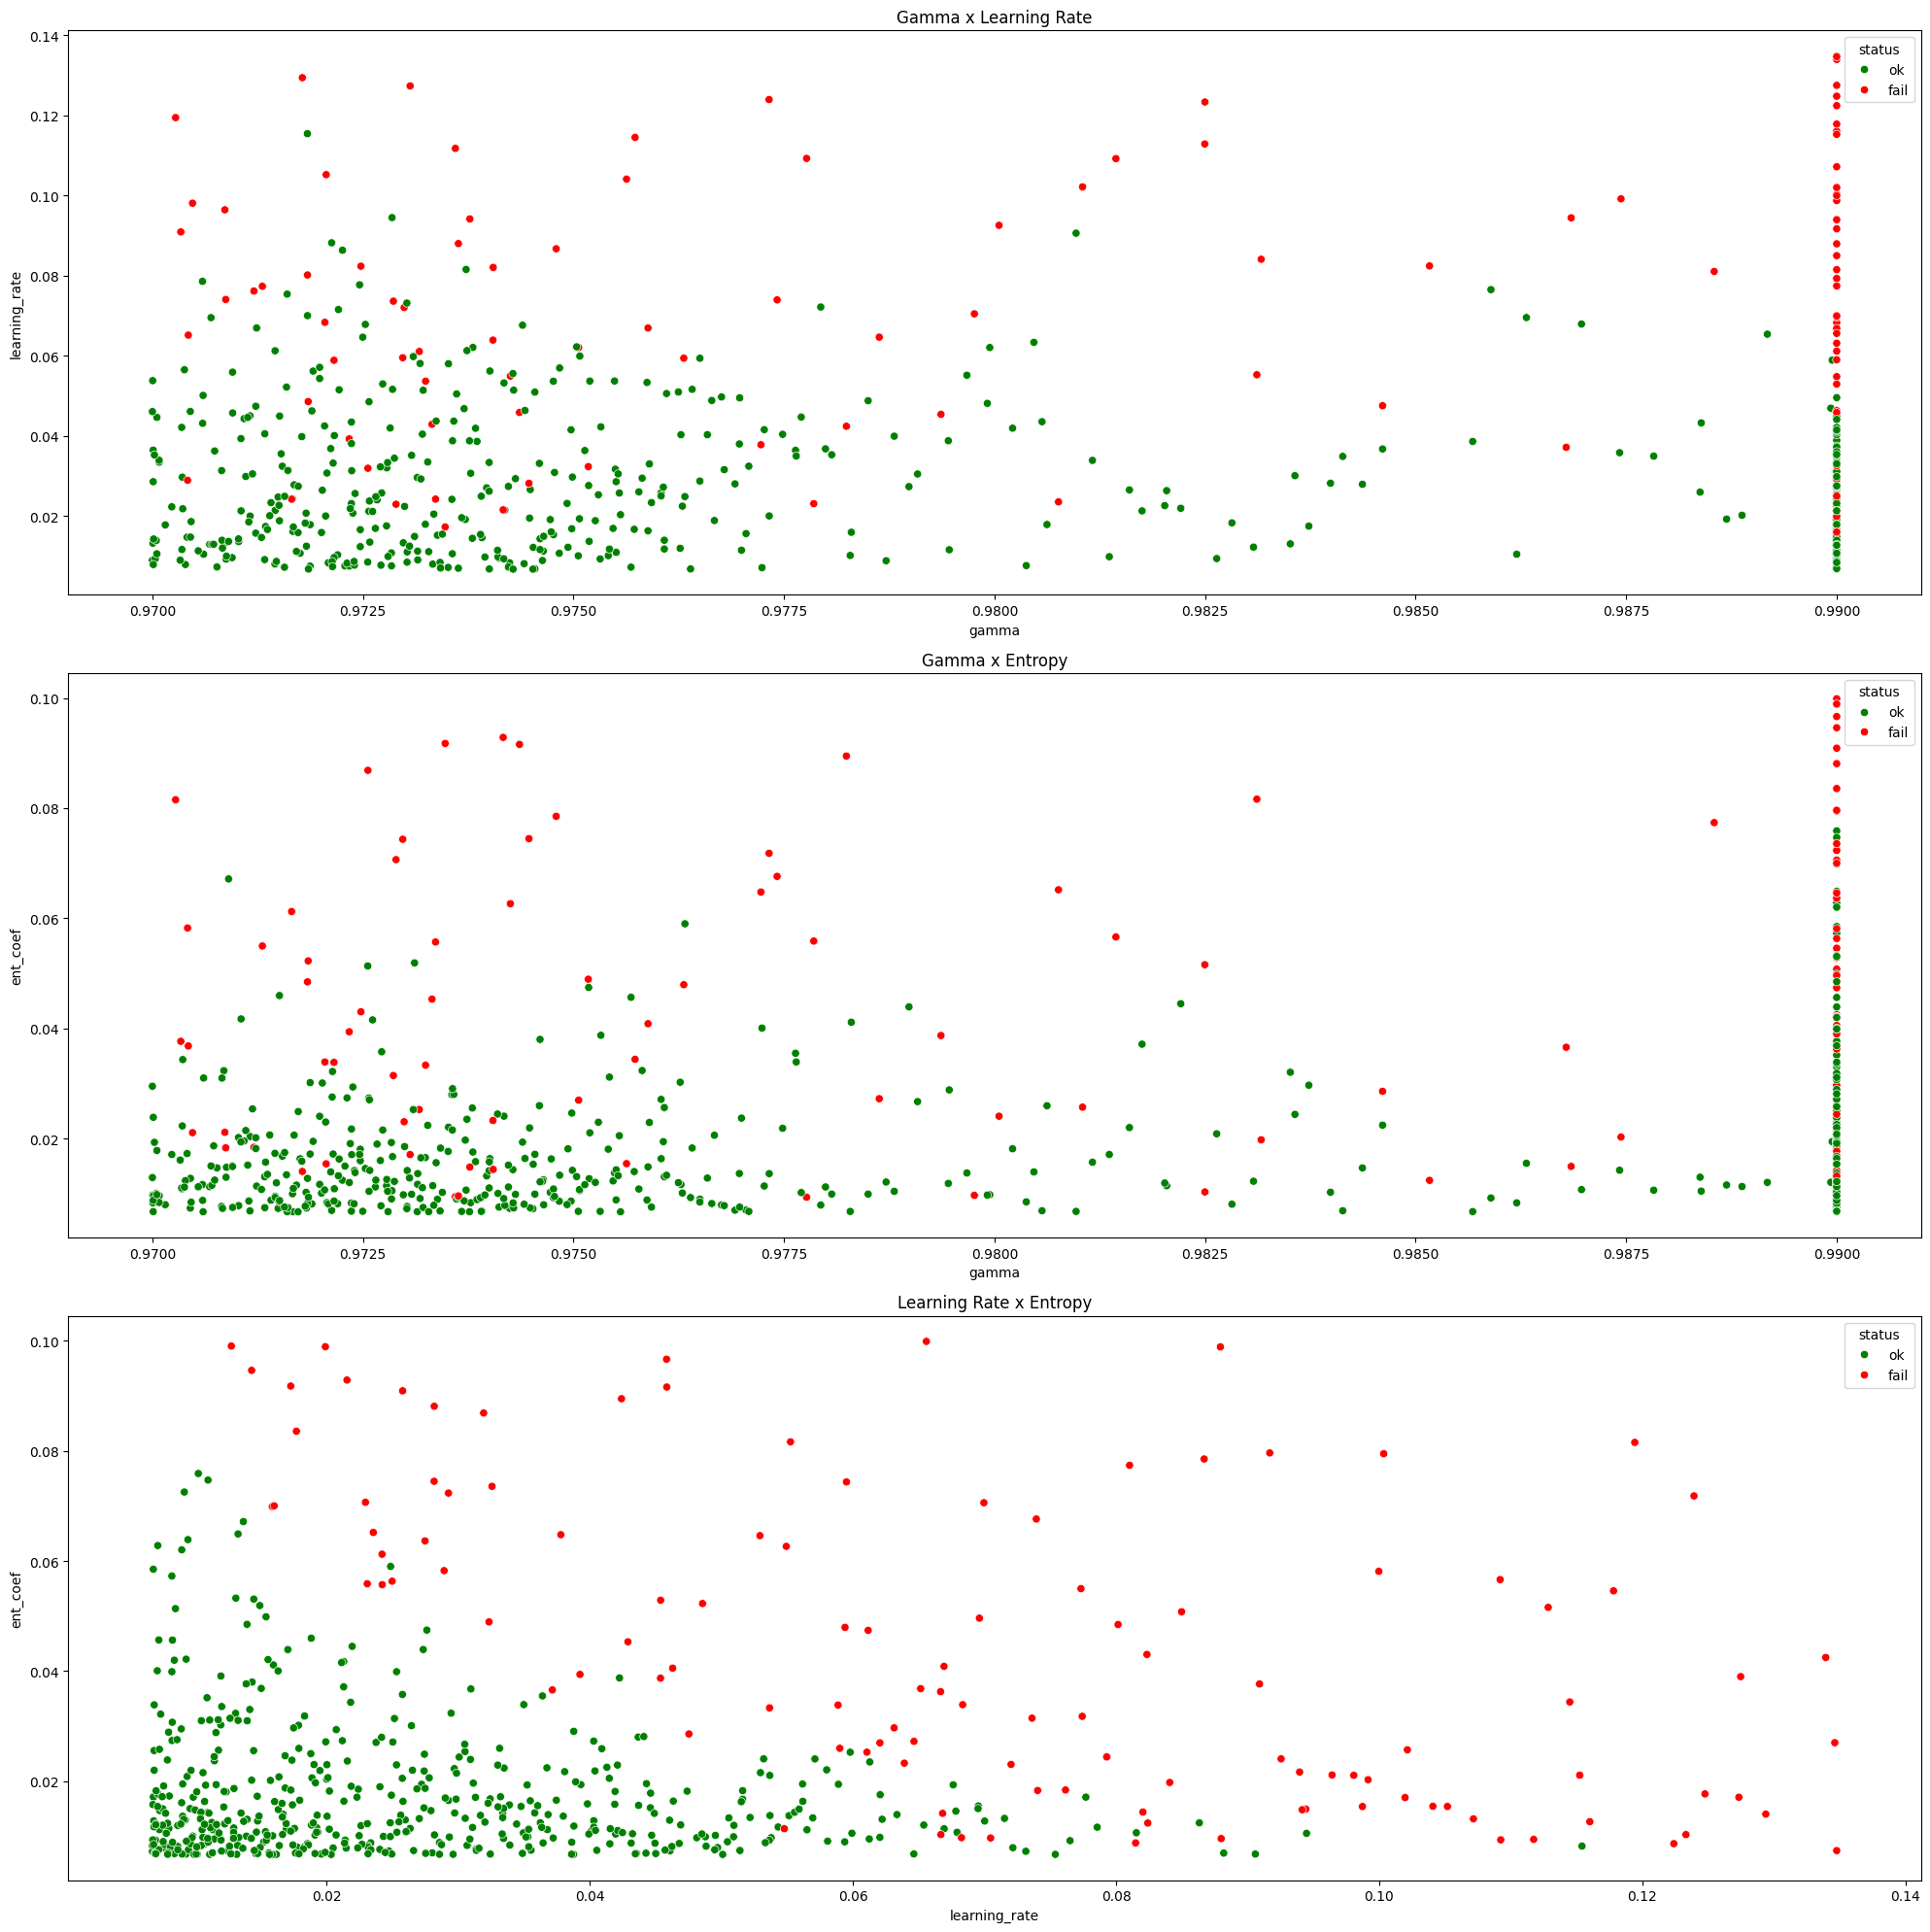

In [35]:
# create 3 figures for the combination of all 3 hyperparameters, learning rate, entropy, and gamma, and I want them stacked with one figure per row and 3 rows to compare the failure distribution of each hyperparameter combination 
# gamma x learning rate, gamma x entropy, learning rate x entropy
# first create the subplot that each figure will go into with 1 column and 3 rows
fig, axs = plt.subplots(3, 1, figsize=(20, 20))
# create the first subplot with gamma x learning rate and status of ok being green and fail being red
custom_palette = sns.color_palette(["green", "red"])
sns.scatterplot(data=results_df_low_entropy, x='gamma', y='learning_rate', hue='status', ax=axs[0], palette=custom_palette)
axs[0].set_title('Gamma x Learning Rate')
# create the second subplot with gamma x entropy and status of ok being green and fail being red
sns.scatterplot(data=results_df_low_entropy, x='gamma', y='ent_coef', hue='status', ax=axs[1], palette=custom_palette)
axs[1].set_title('Gamma x Entropy')
# create the third subplot with learning rate x entropy and status of ok being green and fail being red
sns.scatterplot(data=results_df_low_entropy, x='learning_rate', y='ent_coef', hue='status', ax=axs[2], palette=custom_palette)
axs[2].set_title('Learning Rate x Entropy')
# add some space between each figure
plt.tight_layout()
# plot the figure
plt.show()

## Loss Binary Plots

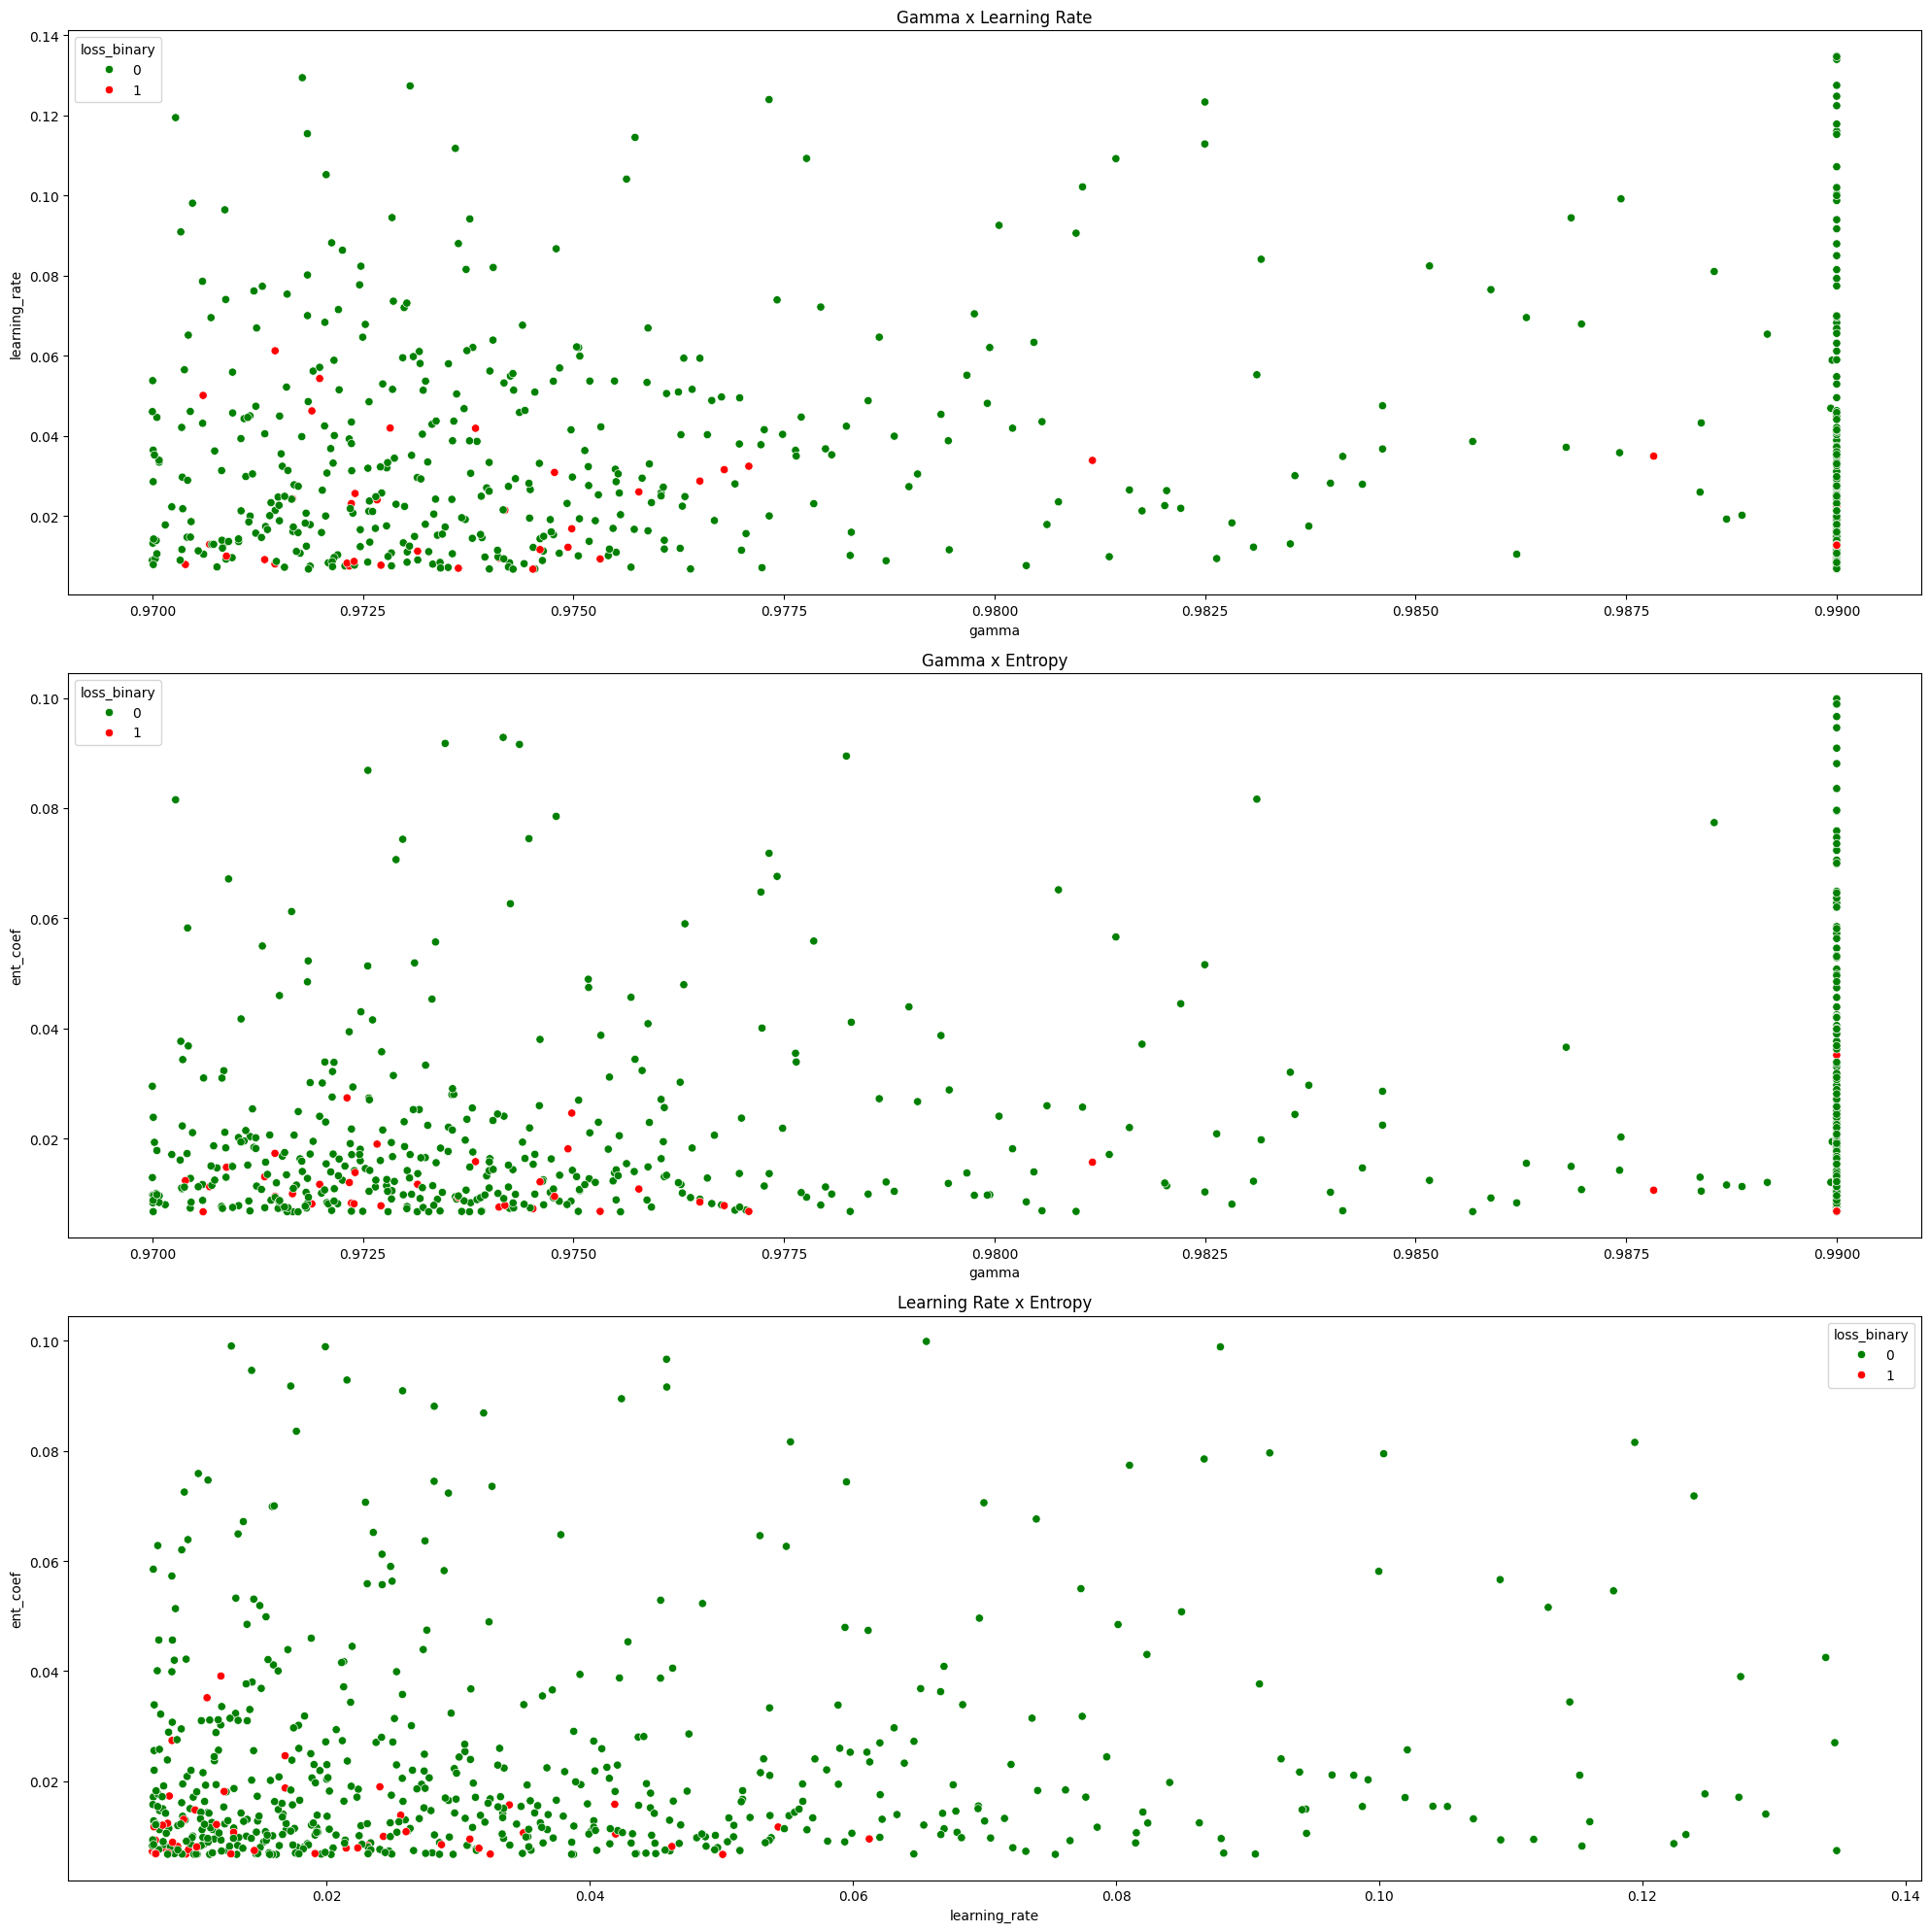

In [36]:
# create 3 figures for the combination of all 3 hyperparameters, learning rate, entropy, and gamma, and I want them stacked with one figure per row and 3 rows to compare the failure distribution of each hyperparameter combination 
# gamma x learning rate, gamma x entropy, learning rate x entropy
# first create the subplot that each figure will go into with 1 column and 3 rows
fig, axs = plt.subplots(3, 1, figsize=(20, 20))
# create the first subplot with gamma x learning rate and loss_binary of ok being green and fail being red
sns.scatterplot(data=results_df_low_entropy, x='gamma', y='learning_rate', hue='loss_binary', ax=axs[0], palette=custom_palette)
axs[0].set_title('Gamma x Learning Rate')
# create the second subplot with gamma x entropy and loss_binary of ok being green and fail being red
sns.scatterplot(data=results_df_low_entropy, x='gamma', y='ent_coef', hue='loss_binary', ax=axs[1], palette=custom_palette)
axs[1].set_title('Gamma x Entropy')
# create the third subplot with learning rate x entropy and loss_binary of ok being green and fail being red
sns.scatterplot(data=results_df_low_entropy, x='learning_rate', y='ent_coef', hue='loss_binary', ax=axs[2], palette=custom_palette)
axs[2].set_title('Learning Rate x Entropy')
# add some space between each figure
plt.tight_layout()
# plot the figure
plt.show()

In [37]:
results_df_low_entropy_negative = results_df_low_entropy[results_df_low_entropy['loss'] < 0]

## Non-Binary Loss Plots

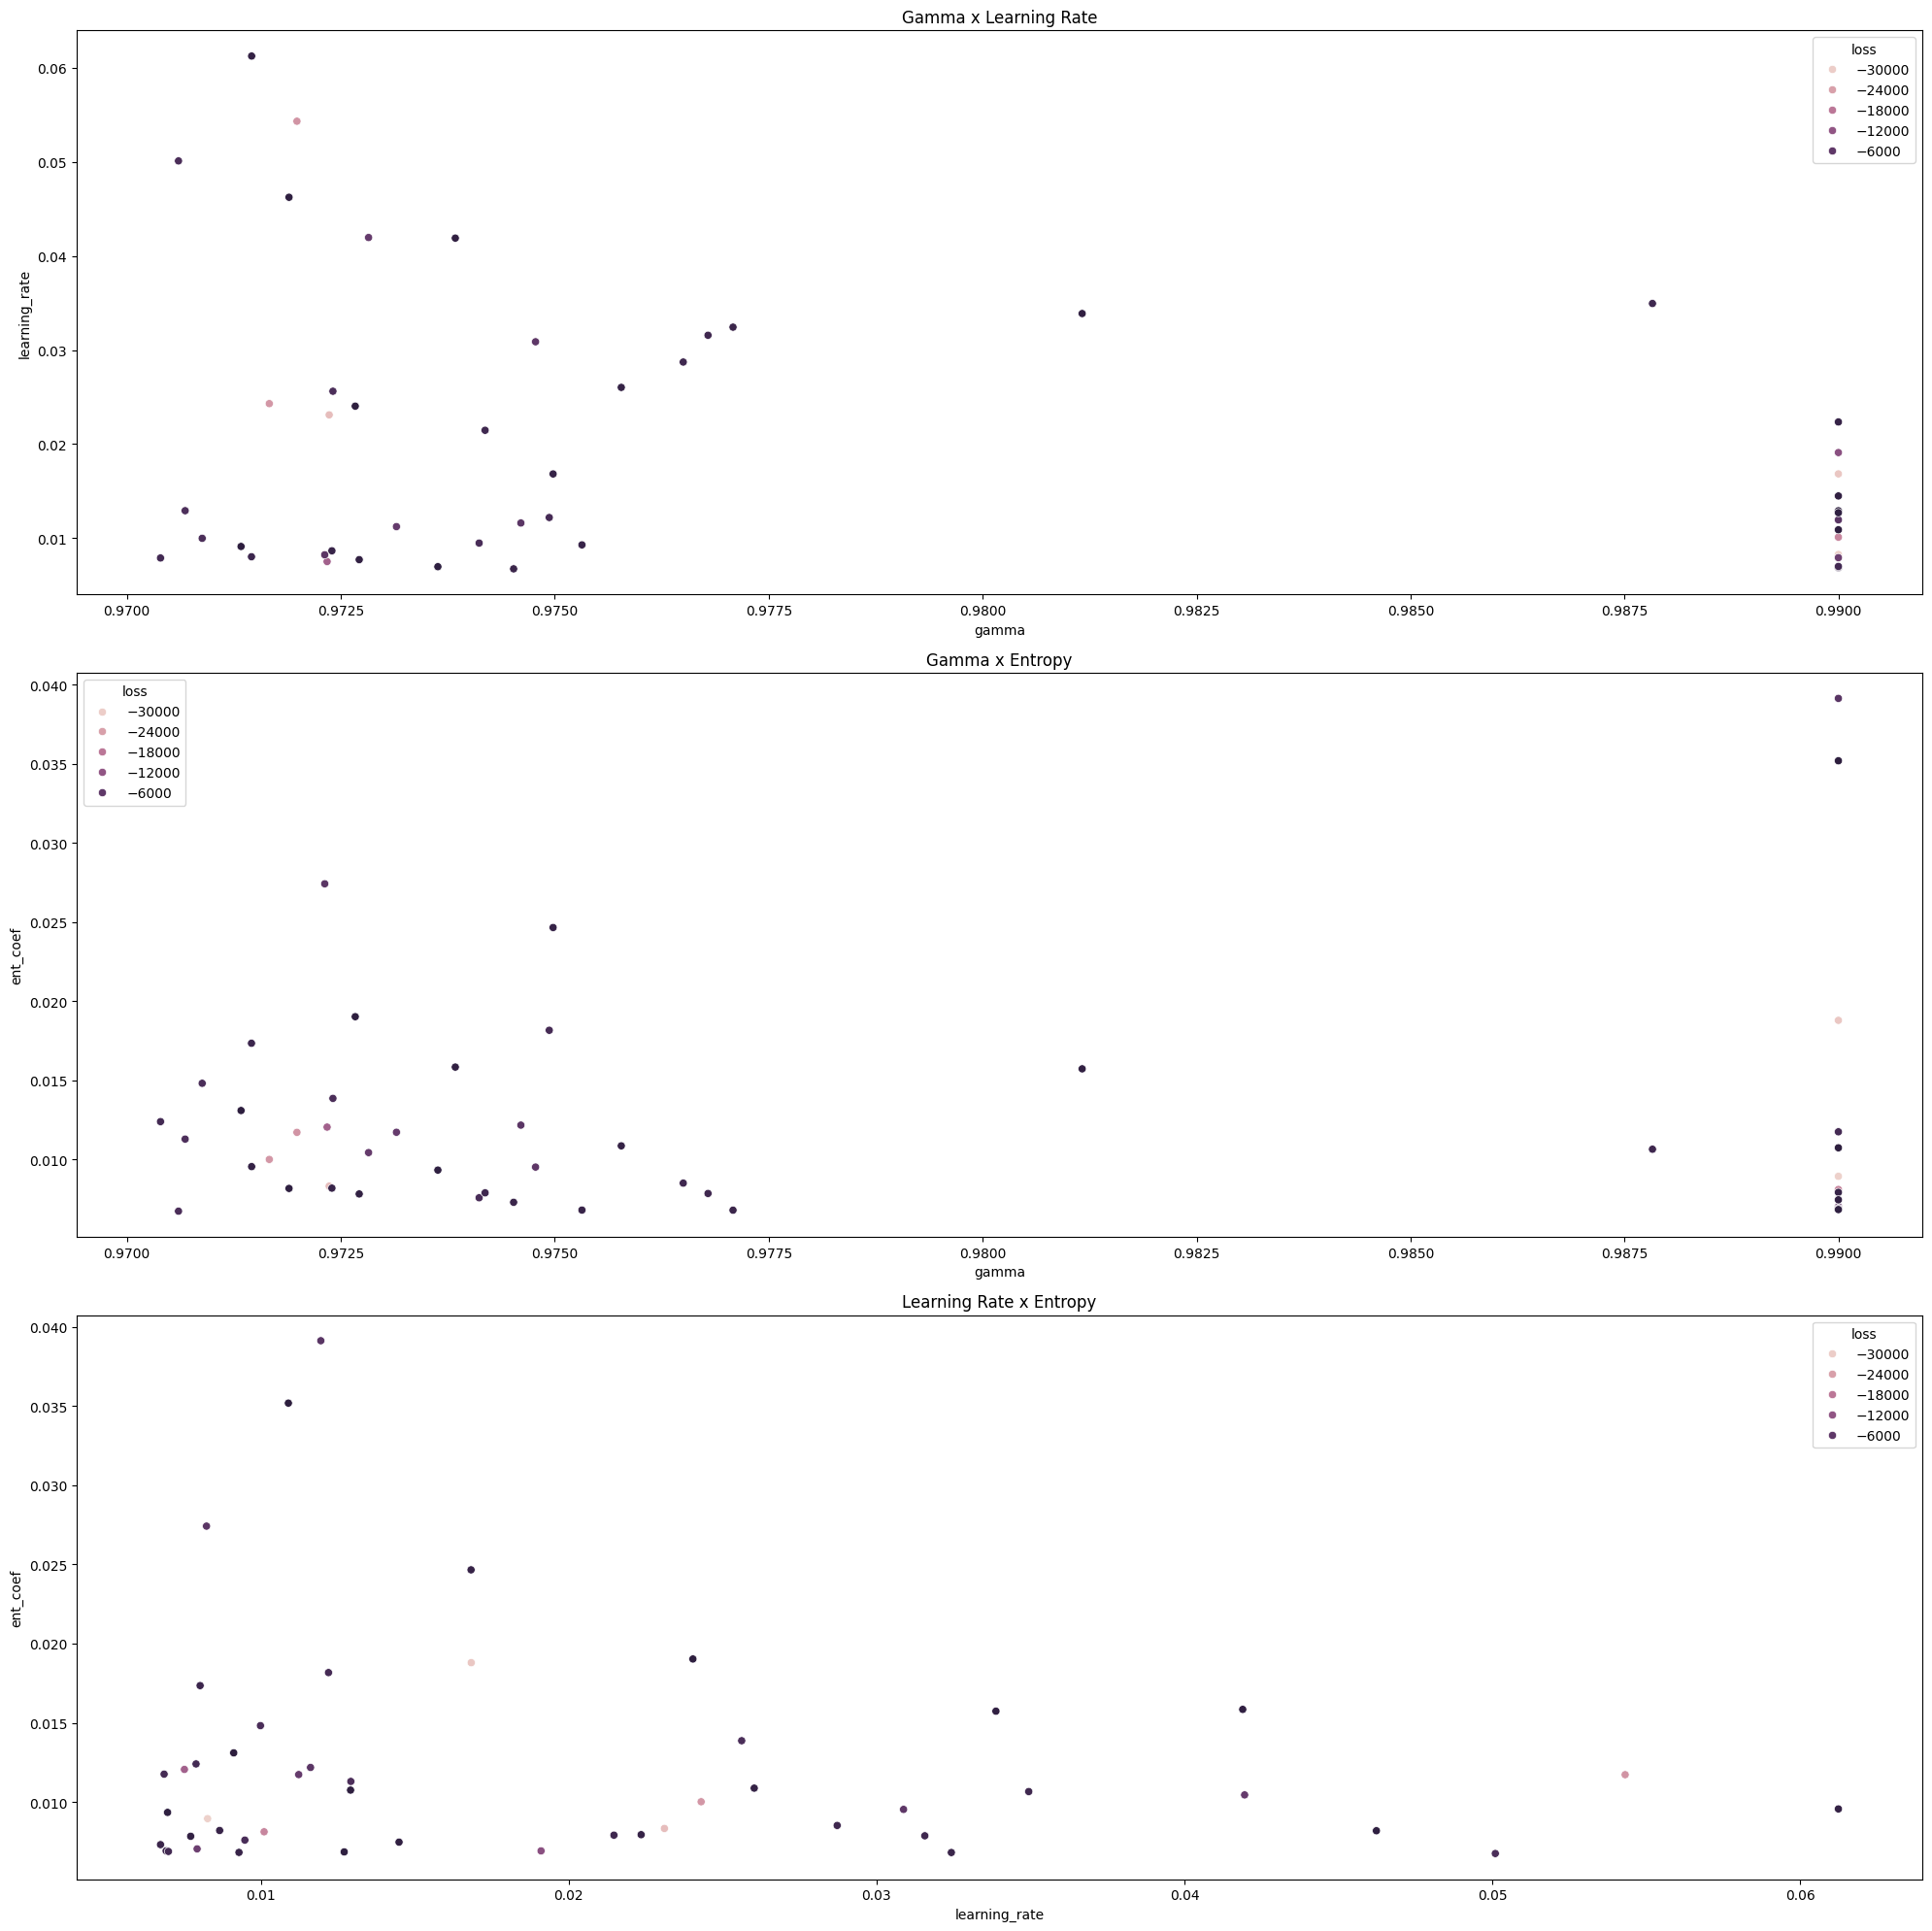

In [38]:
# create 3 figures for the combination of all 3 hyperparameters, learning rate, entropy, and gamma, and I want them stacked with one figure per row and 3 rows to compare the failure distribution of each hyperparameter combination 
# gamma x learning rate, gamma x entropy, learning rate x entropy
# first create the subplot that each figure will go into with 1 column and 3 rows
fig, axs = plt.subplots(3, 1, figsize=(20, 20))
# create the first subplot with gamma x learning rate and loss of ok being green and fail being red
sns.scatterplot(data=results_df_low_entropy_negative, x='gamma', y='learning_rate', hue='loss', ax=axs[0])
axs[0].set_title('Gamma x Learning Rate')
# create the second subplot with gamma x entropy and loss of ok being green and fail being red
sns.scatterplot(data=results_df_low_entropy_negative, x='gamma', y='ent_coef', hue='loss', ax=axs[1])
axs[1].set_title('Gamma x Entropy')
# create the third subplot with learning rate x entropy and loss of ok being green and fail being red
sns.scatterplot(data=results_df_low_entropy_negative, x='learning_rate', y='ent_coef', hue='loss', ax=axs[2])
axs[2].set_title('Learning Rate x Entropy')
# add some space between each figure
plt.tight_layout()
# plot the figure
plt.show()

## Hyperparameters vs loss plots

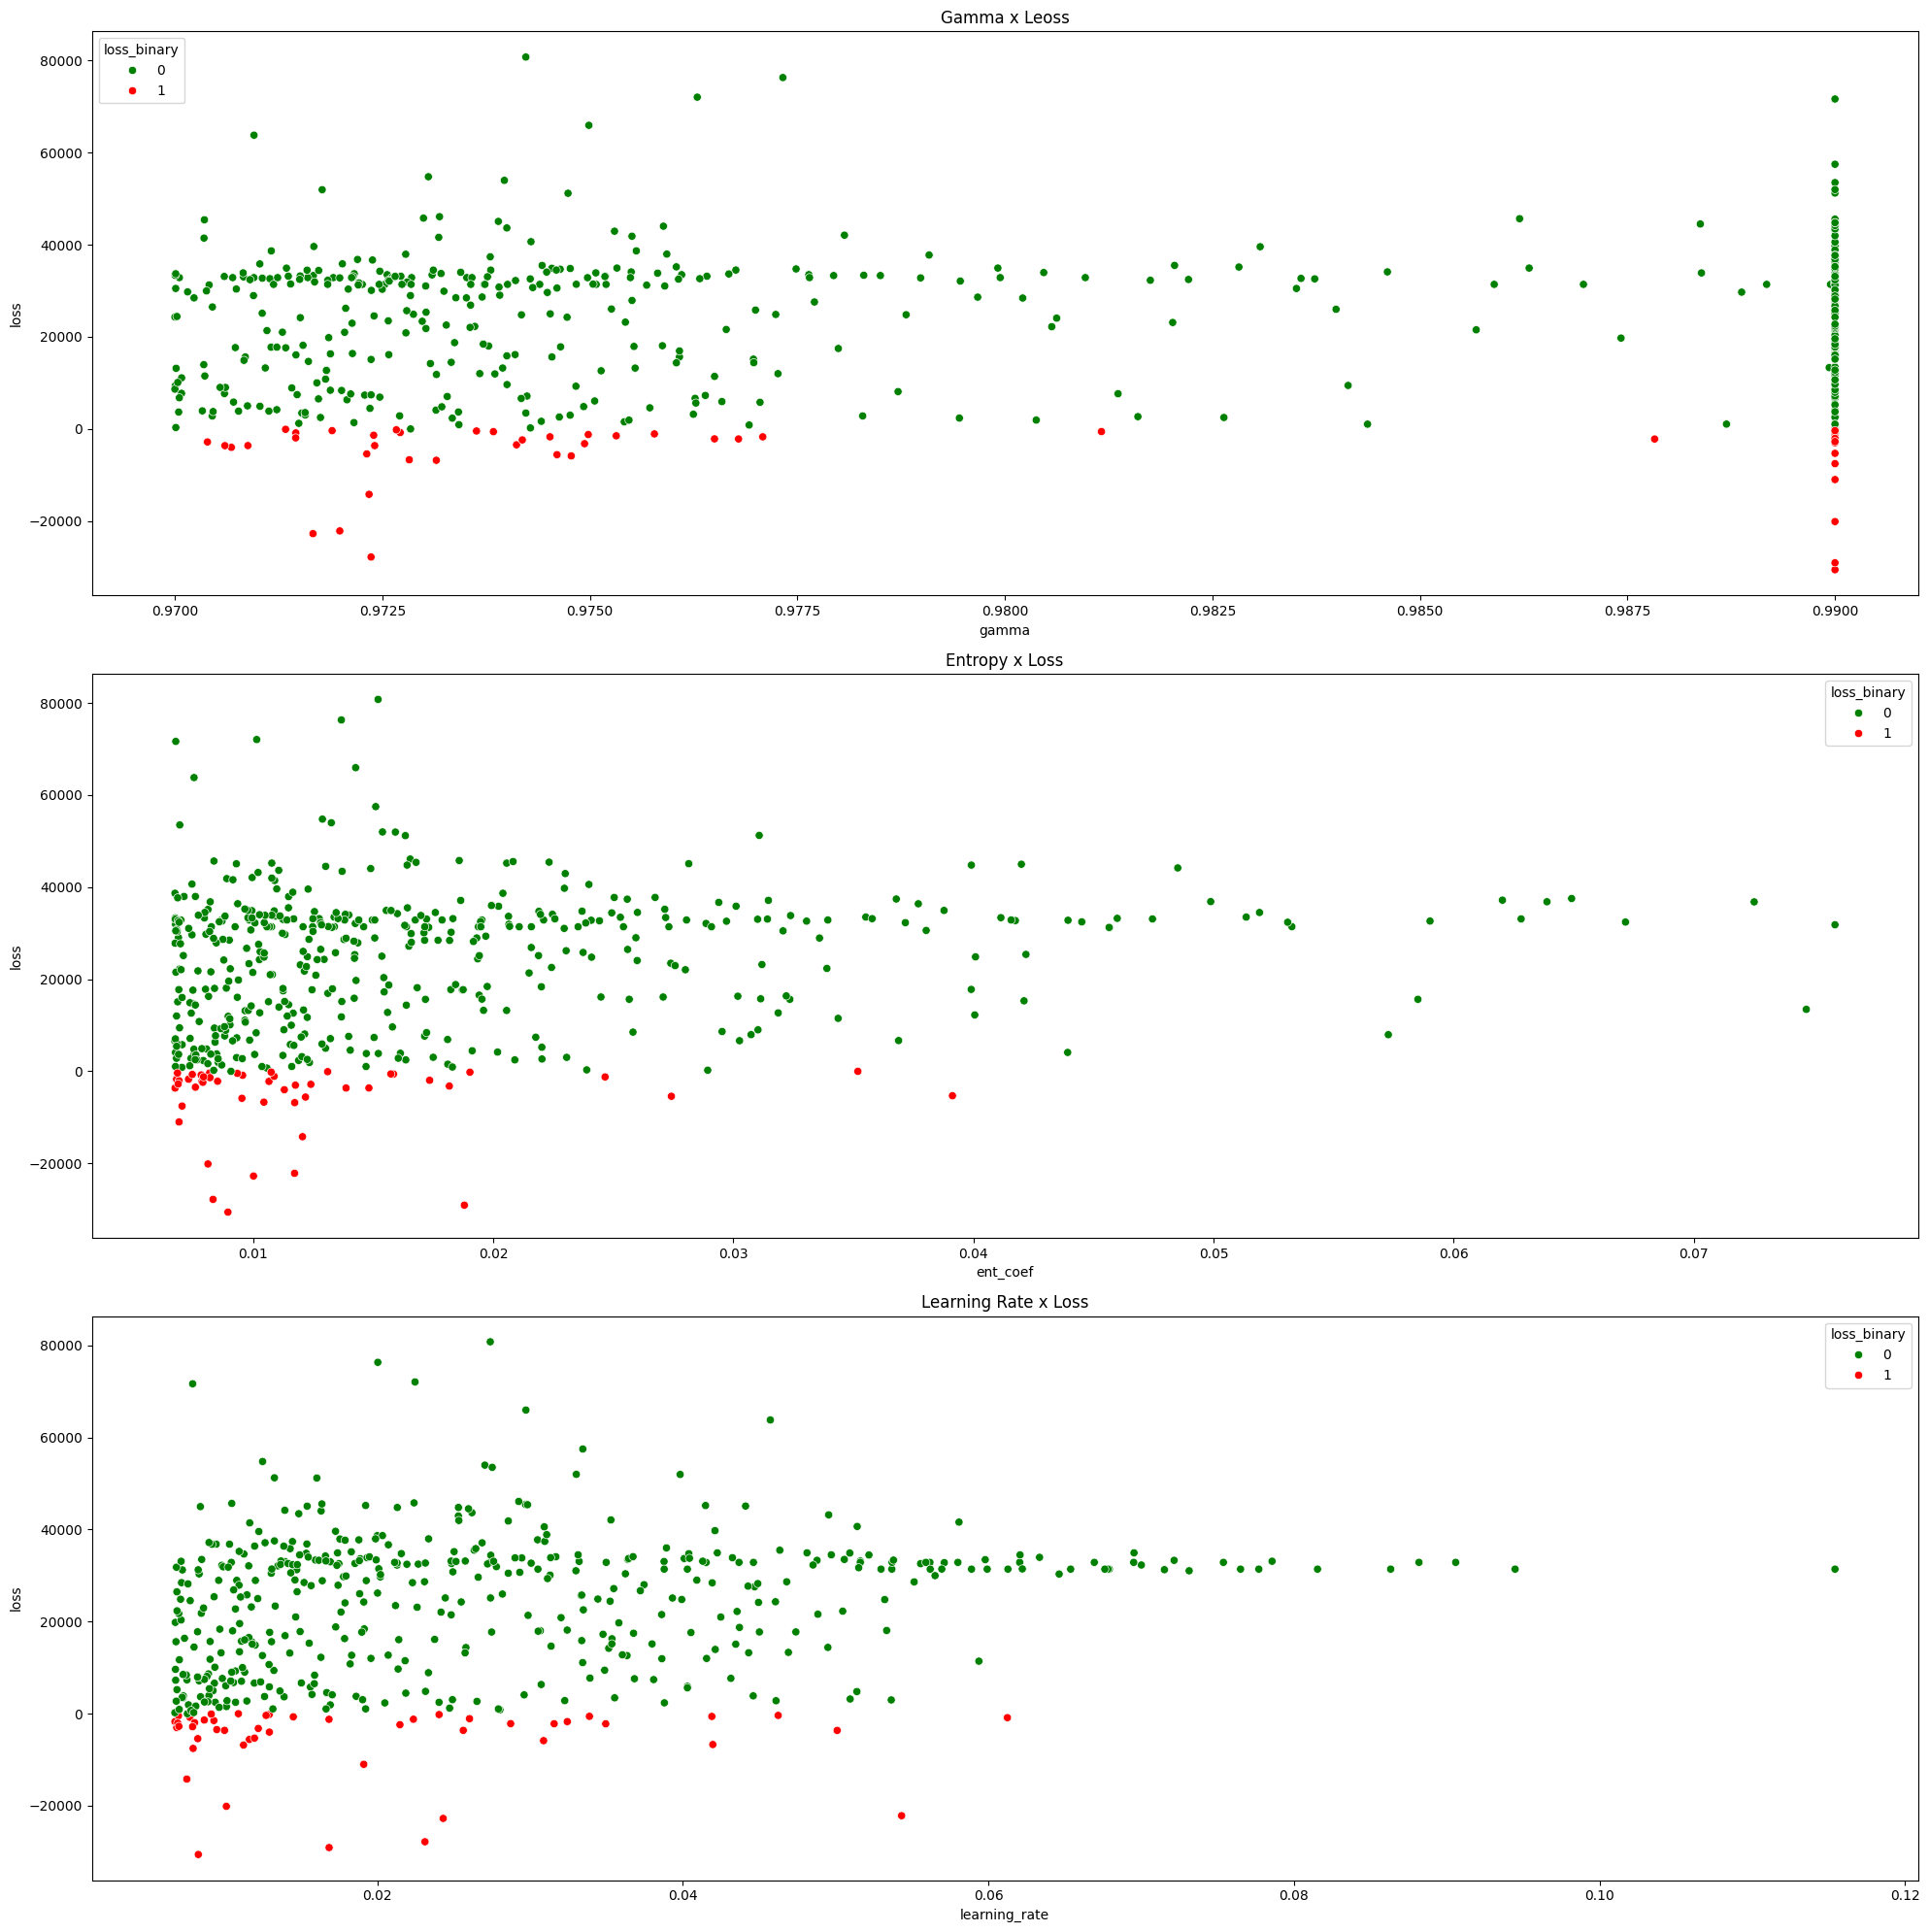

In [39]:
# create 3 figures for the combination of all 3 hyperparameters, learning rate, entropy, and gamma, and I want them stacked with one figure per row and 3 rows to compare the failure distribution of each hyperparameter combination 
# gamma x learning rate, gamma x entropy, learning rate x entropy
# first create the subplot that each figure will go into with 1 column and 3 rows
fig, axs = plt.subplots(3, 1, figsize=(20, 20))
# create the first subplot with gamma x learning rate and loss_binary of ok being green and fail being red
sns.scatterplot(data=results_df_low_entropy, x='gamma', y='loss', hue='loss_binary', ax=axs[0], palette=custom_palette)
axs[0].set_title('Gamma x Loss')
# create the second subplot with gamma x entropy and loss_binary of ok being green and fail being red
sns.scatterplot(data=results_df_low_entropy, x='ent_coef', y='loss', hue='loss_binary', ax=axs[1], palette=custom_palette)
axs[1].set_title('Entropy x Loss')
# create the third subplot with learning rate x entropy and loss_binary of ok being green and fail being red
sns.scatterplot(data=results_df_low_entropy, x='learning_rate', y='loss', hue='loss_binary', ax=axs[2], palette=custom_palette)
axs[2].set_title('Learning Rate x Loss')
# add some space between each figure
plt.tight_layout()
# plot the figure
plt.show()

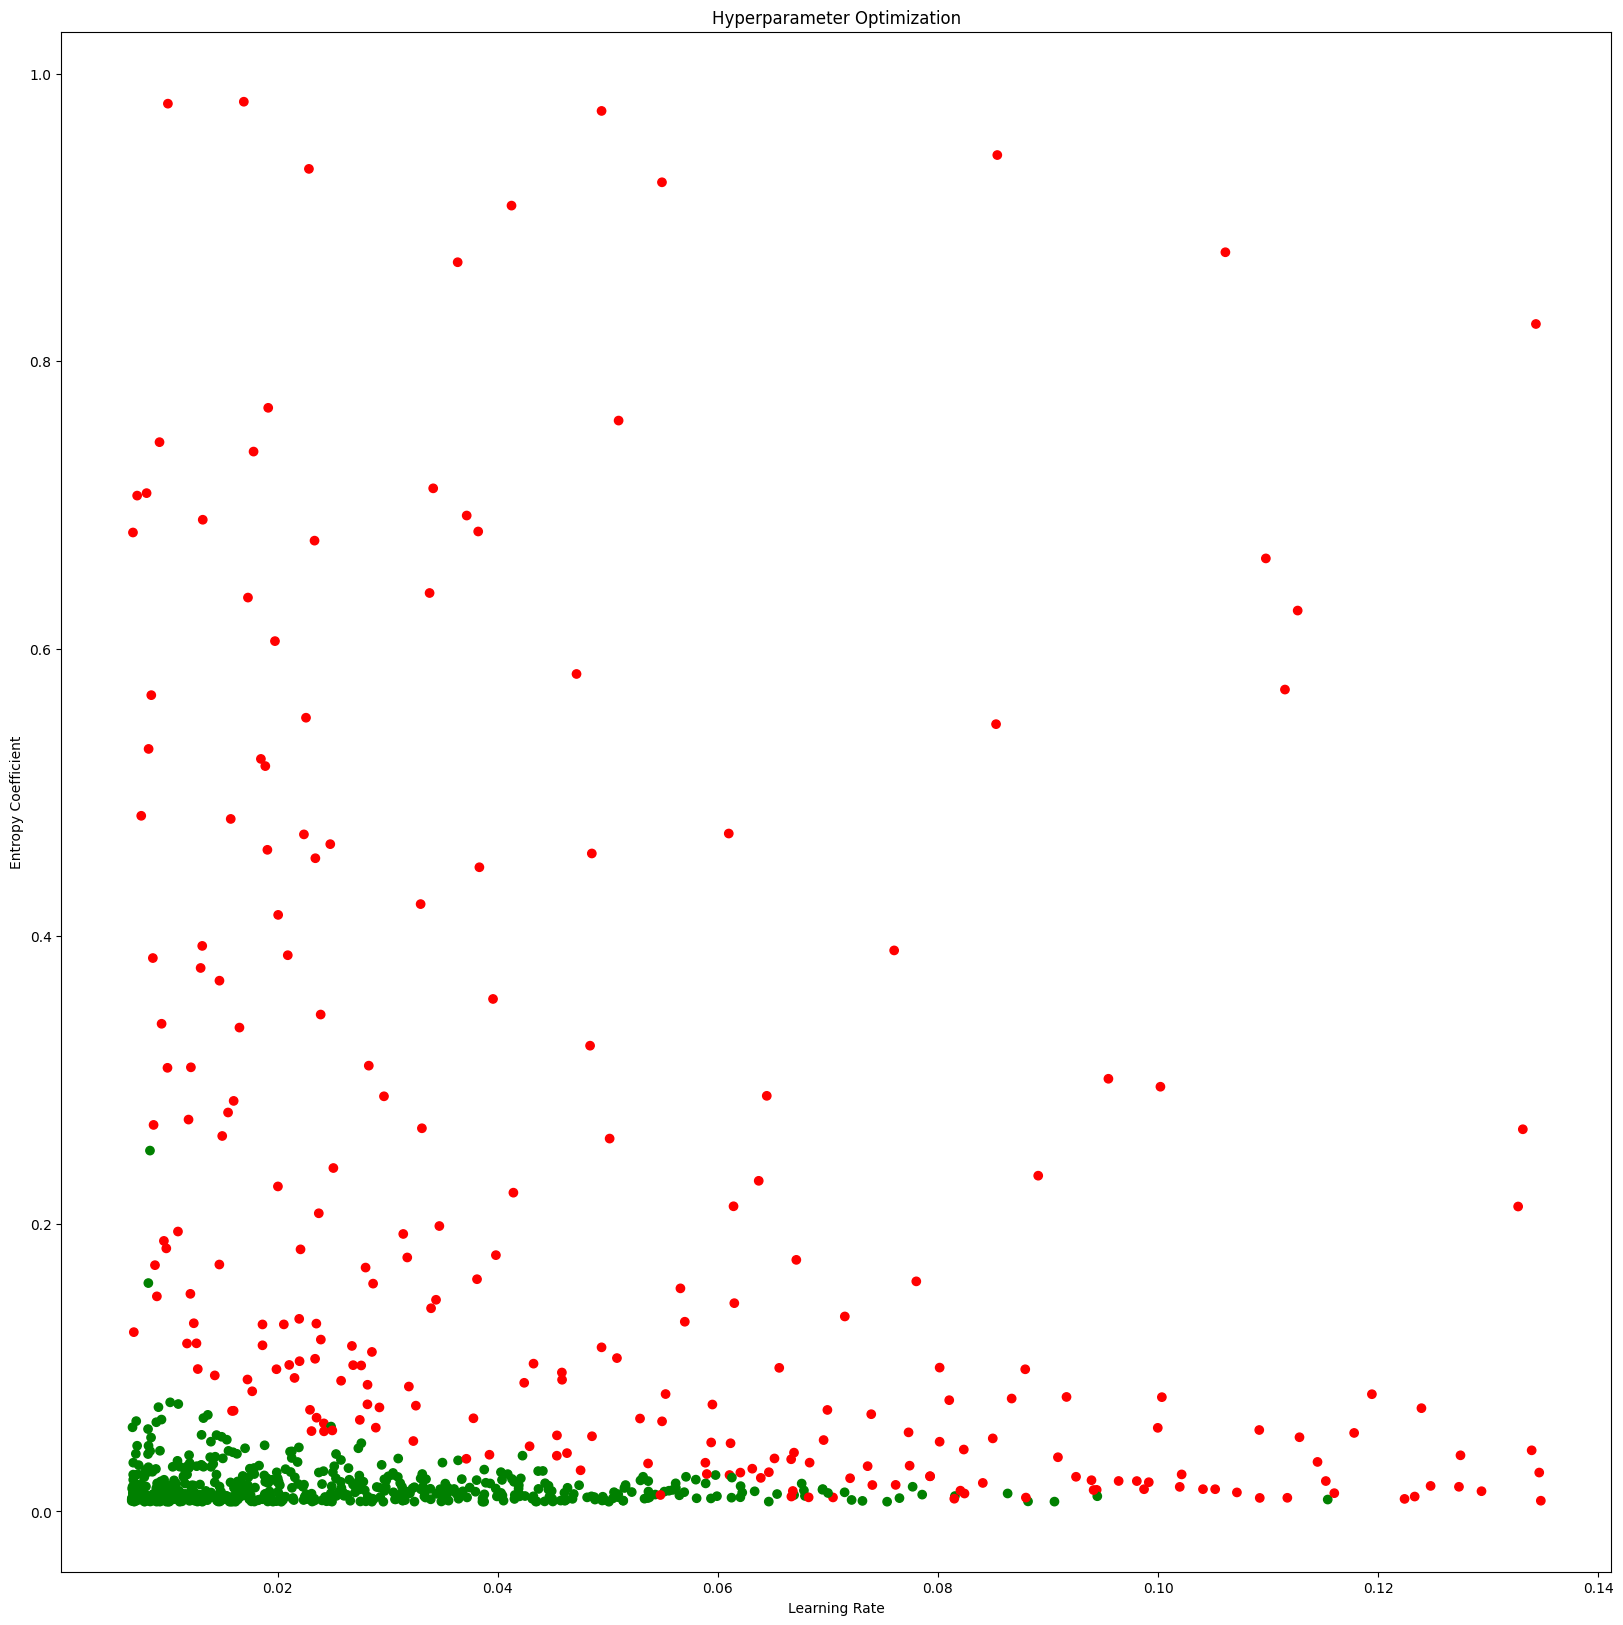

In [24]:
# visualize the parameters that cause failures in the objective function

# create a graph that has learning rate on the x-axis and ent_coef on the y-axis, 
# then the color of the points is whether the status is ok or fail, green for ok and red for fail

fig, ax = plt.subplots()
scatter = ax.scatter(results_df['learning_rate'], results_df['ent_coef'], 
                     c=results_df['status'].apply(lambda x: 'green' if x == 'ok' else 'red'))
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Entropy Coefficient')
ax.set_title('Hyperparameter Optimization')
# y lim to 0.2
plt.ylim(0, 0.1)
# x lim to 0.05
# plt.xlim(0, 0.05)
# plt.legend(handles=scatter.legend_elements()[0], labels=['OK', 'Fail'])
# increase the plot size
fig.set_size_inches(20, 20)
plt.show()


# Best Hyperparameters vs Next Week

In [65]:
# only successes 
results_df_success = results_df[results_df['status'] == 'ok']
results_df_success_negative = results_df_success[results_df_success['loss'] < 0]
# sort values from least to greatest loss
results_df_success_negative_sorted = results_df_success_negative.sort_values(by='loss', ascending=True)
results_df_success_negative_sorted

,loss,status,eval_time,iteration,learning_rate,ent_coef,gamma
542,-30583.519427,ok,1.713828e+09,0,0.008273,0.008946,0.990000
583,-29072.219647,ok,1.713836e+09,7,0.016835,0.018795,0.990000
288,-27815.450535,ok,1.714005e+09,7,0.023110,0.008327,0.972364
36,-22744.360838,ok,1.713905e+09,7,0.024302,0.010013,0.971664
78,-22151.250214,ok,1.713922e+09,7,0.054313,0.011722,0.971987
546,-20122.022387,ok,1.713829e+09,0,0.010108,0.008115,0.990000
418,-14206.933691,ok,1.714052e+09,7,0.007520,0.012053,0.972340
630,-10996.556853,ok,1.713846e+09,14,0.019103,0.006911,0.990000
543,-7542.177467,ok,1.713828e+09,0,0.007932,0.007038,0.990000
147,-6806.875252,ok,1.713943e+09,7,0.011231,0.011728,0.973150


In [66]:
env_train = MtEnv(
    original_simulator=sim_train,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=list(symbols[1]['EURUSD'].loc[:(max_friday - pd.DateOffset(days=7)), :].index),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [69]:
seed = 2024  # random seed
total_num_episodes = 10

# print ("env_name                 :", env_name)
print ("seed                     :", seed)

# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

seed                     : 2024


In [67]:
def objective_testing(params):
    learning_timesteps = 50 #params['learning_timesteps']
    ent_coef = params['ent_coef']
    gamma = params['gamma'] #0.99 #
    learning_rate = params['learning_rate']#0.0003#

    total_learning_timesteps = learning_timesteps * 1000
    step_key = f'{learning_timesteps}K'
    policy_dict = PPO.policy_aliases
    policy = policy_dict.get('MultiInputPolicy')
    class_name = type(PPO).__qualname__
    plot_key = f'{class_name}_rewards_'+step_key
    try:
        rewards, orders = train_val_model(PPO, policy, env_train, env_testing, seed, step_key,  
                                                    learning_rate, gamma, ent_coef, total_learning_timesteps)
    except:
        print(f'''there was an error with those parameters: timesteps: {learning_timesteps}, \n
              ent_coef: {ent_coef}, gamma: {gamma}, learning_rate: {learning_rate}''')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}
    # timesteps_models_dict[step_key] = models_dict
    min_rewards, avg_rewards, max_rewards, = print_stats(rewards, 'Reward')
    print_stats(orders, 'Orders')
    label = f'Avg. {avg_rewards:>7.2f} : {class_name} - {step_key}'
    plot_data[plot_key] = rewards
    plot_settings[plot_key] = {'label': label}
    params['avg_orders'] = np.mean(orders)       

    return {'loss': -avg_rewards, 'status': STATUS_OK, 'eval_time': time.time(), 'parameters': params}

## Results for best models from hyperparameter search

In [ ]:
# how does the model perform on the following week
hyperparameter_tune_weekly_result_next_week = []
results_df_success_negative_no_zero = results_df_success_negative_sorted[results_df_success_negative_sorted['iteration'] == 7]
for row in range(0, len(results_df_success_negative_no_zero)):
    print(f"{'-'*40} loss: {round(results_df_success_negative_no_zero.iloc[row, 0], 2)} {'-'*40}")
    i = results_df_success_negative_no_zero.iloc[row, 3] - 7    
    parameters = {
        'learning_rate': results_df_success_negative_no_zero.iloc[row, 4],
        'ent_coef': results_df_success_negative_no_zero.iloc[row, 5],
        'gamma': results_df_success_negative_no_zero.iloc[row, 6]
    }
    result = objective_testing(parameters)
    hyperparameter_tune_weekly_result_next_week.append(result)
    # print(result)

In [73]:
results_df_hyperparameter_tuned = pd.DataFrame()
for idx, result in enumerate(hyperparameter_tune_weekly_result_next_week):
    result['learning_rate'] = result['parameters']['learning_rate']
    result['ent_coef'] = result['parameters']['ent_coef']
    result['gamma'] = result['parameters']['gamma']
    result['orders'] = result['parameters']['orders']
    del result['parameters']
    new_row = pd.DataFrame(result, index=[idx])
    results_df_hyperparameter_tuned = pd.concat([results_df_hyperparameter_tuned, new_row], axis=0)
results_df_hyperparameter_tuned

KeyError: 'parameters'

In [74]:
results_df_hyperparameter_tuned

""


In [21]:
lr = results_df_success_negative_sorted.iloc[1,4]
entropy = results_df_success_negative_sorted.iloc[1,5]
gamma = results_df_success_negative_sorted.iloc[1,6]

In [28]:
seed = 2024
rewards, orders = train_val_model(PPO, 'MultiInputPolicy', env_train, env_testing, seed, '50K',  
                                                    lr, gamma, entropy, 250_000)

--------------------------------------------------------------------------------
entropy: 0.018794601624451752, learning rate: 0.016835273638875447, gamma: 0.99
Episode: 0, Avg. Reward: -57278.267, # of orders: 42.000
Episode: 1, Avg. Reward: 47926.120, # of orders: 41.000
Episode: 2, Avg. Reward: -1691.366, # of orders: 33.667
Episode: 3, Avg. Reward: -26812.380, # of orders: 29.250
Episode: 4, Avg. Reward: -44937.931, # of orders: 29.000
Episode: 5, Avg. Reward: -22902.208, # of orders: 31.500
Episode: 6, Avg. Reward: -10138.943, # of orders: 32.714
Episode: 7, Avg. Reward: -22180.657, # of orders: 31.250
Episode: 8, Avg. Reward: -30459.893, # of orders: 31.444
Episode: 9, Avg. Reward: -25688.244, # of orders: 31.700


In [29]:
rewards

[-57278.26658870428,
 153130.5072992629,
 -100926.33828036813,
 -102175.42191114534,
 -117440.13420546758,
 87276.4034813203,
 66440.65071187424,
 -106472.65362666041,
 -96693.7871229121,
 17256.602681774937]

In [75]:
# Assuming env_orders is your DataFrame and 'column_name' is the name of the column you want to normalize
orders = env_testing.render()['orders']
# Calculate the mean of the column
mean_value = orders['Volume'].mean()

# Normalize the column to have a mean of 1
orders['Volume_normalized'] = orders['Volume'] / mean_value
orders

,Id,Symbol,Type,Volume,Entry Time,Entry Price,Exit Time,Exit Price,Exit Balance,Exit Equity,Profit,Margin,Fee,Closed,Volume_normalized
0,7,EURUSD,Sell,100.00,2024-04-11 16:00:00+00:00,1.07346,2024-04-11 18:00:00+00:00,1.07211,198979.883661,198979.883661,12621.868860,107346.0000,0.000088,True,1.236727
1,6,EURUSD,Sell,100.00,2024-04-10 11:00:00+00:00,1.08604,2024-04-10 12:00:00+00:00,1.08616,186358.014801,186358.014801,-2807.147472,108604.0000,0.000161,True,1.236727
2,5,EURUSD,Sell,100.00,2024-04-10 09:00:00+00:00,1.08532,2024-04-10 11:00:00+00:00,1.08604,189165.162273,189165.162273,-8172.668444,108532.0000,0.000097,True,1.236727
3,4,EURUSD,Sell,100.00,2024-04-08 23:00:00+00:00,1.08585,2024-04-09 00:00:00+00:00,1.08582,197337.830717,197337.830717,-652.167021,108585.0000,0.000095,True,1.236727
4,3,EURUSD,Sell,63.87,2024-04-08 20:00:00+00:00,1.08578,2024-04-08 22:00:00+00:00,1.08567,197989.997738,197989.997738,-142.248257,69348.7686,0.000132,True,0.789898
5,2,EURUSD,Buy,40.47,2024-04-08 18:00:00+00:00,1.08527,2024-04-08 19:00:00+00:00,1.08500,198132.245994,198132.245994,-1513.175363,43920.8769,0.000104,True,0.500504
6,1,EURUSD,Sell,61.67,2024-04-08 17:00:00+00:00,1.08532,2024-04-08 18:00:00+00:00,1.08527,199645.421358,199645.421358,-354.578642,66931.6844,0.000107,True,0.762690


In [82]:
my_profit_calculation(orders, 0.001)

(-0.07423127659475648, -12.549596831034057)

In [76]:
orders['Volume_normalized'].mean()

1.0000000000000002

In [33]:
env_testing.render('advanced_figure', time_format="%Y-%m-%d")

In [30]:
# make a sound when the code is done
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 2000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

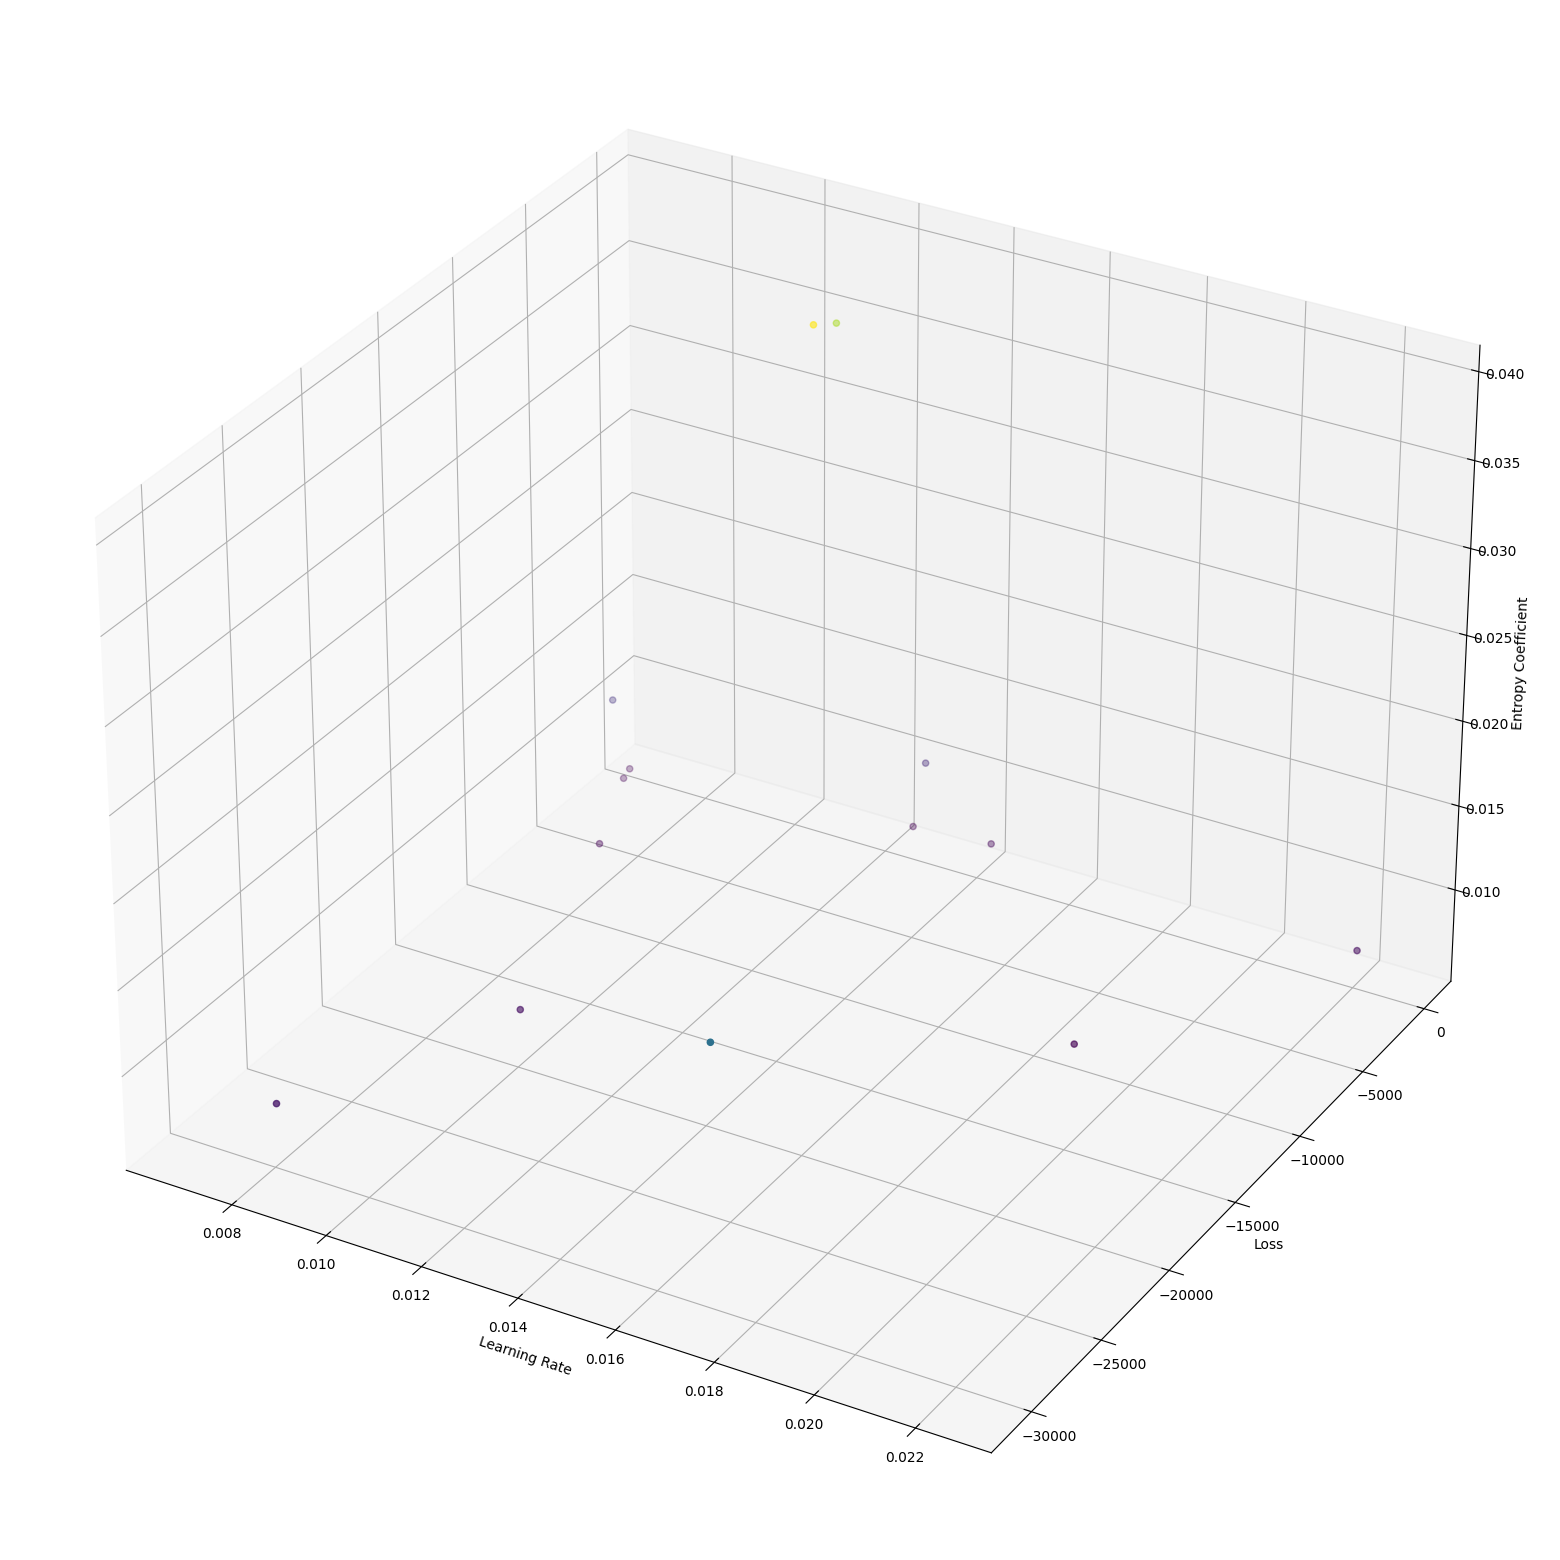

In [28]:
# generate a 3d plot of the learning rate, ent_coef, and loss
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = results_df_success_negative['learning_rate']
y = results_df_success_negative['loss']
z = results_df_success_negative['ent_coef']

ax.scatter(x, y, z, c=z, cmap='viridis')

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Loss')
ax.set_zlabel('Entropy Coefficient')

# increase the plot size
fig.set_size_inches(20, 20)

plt.show()


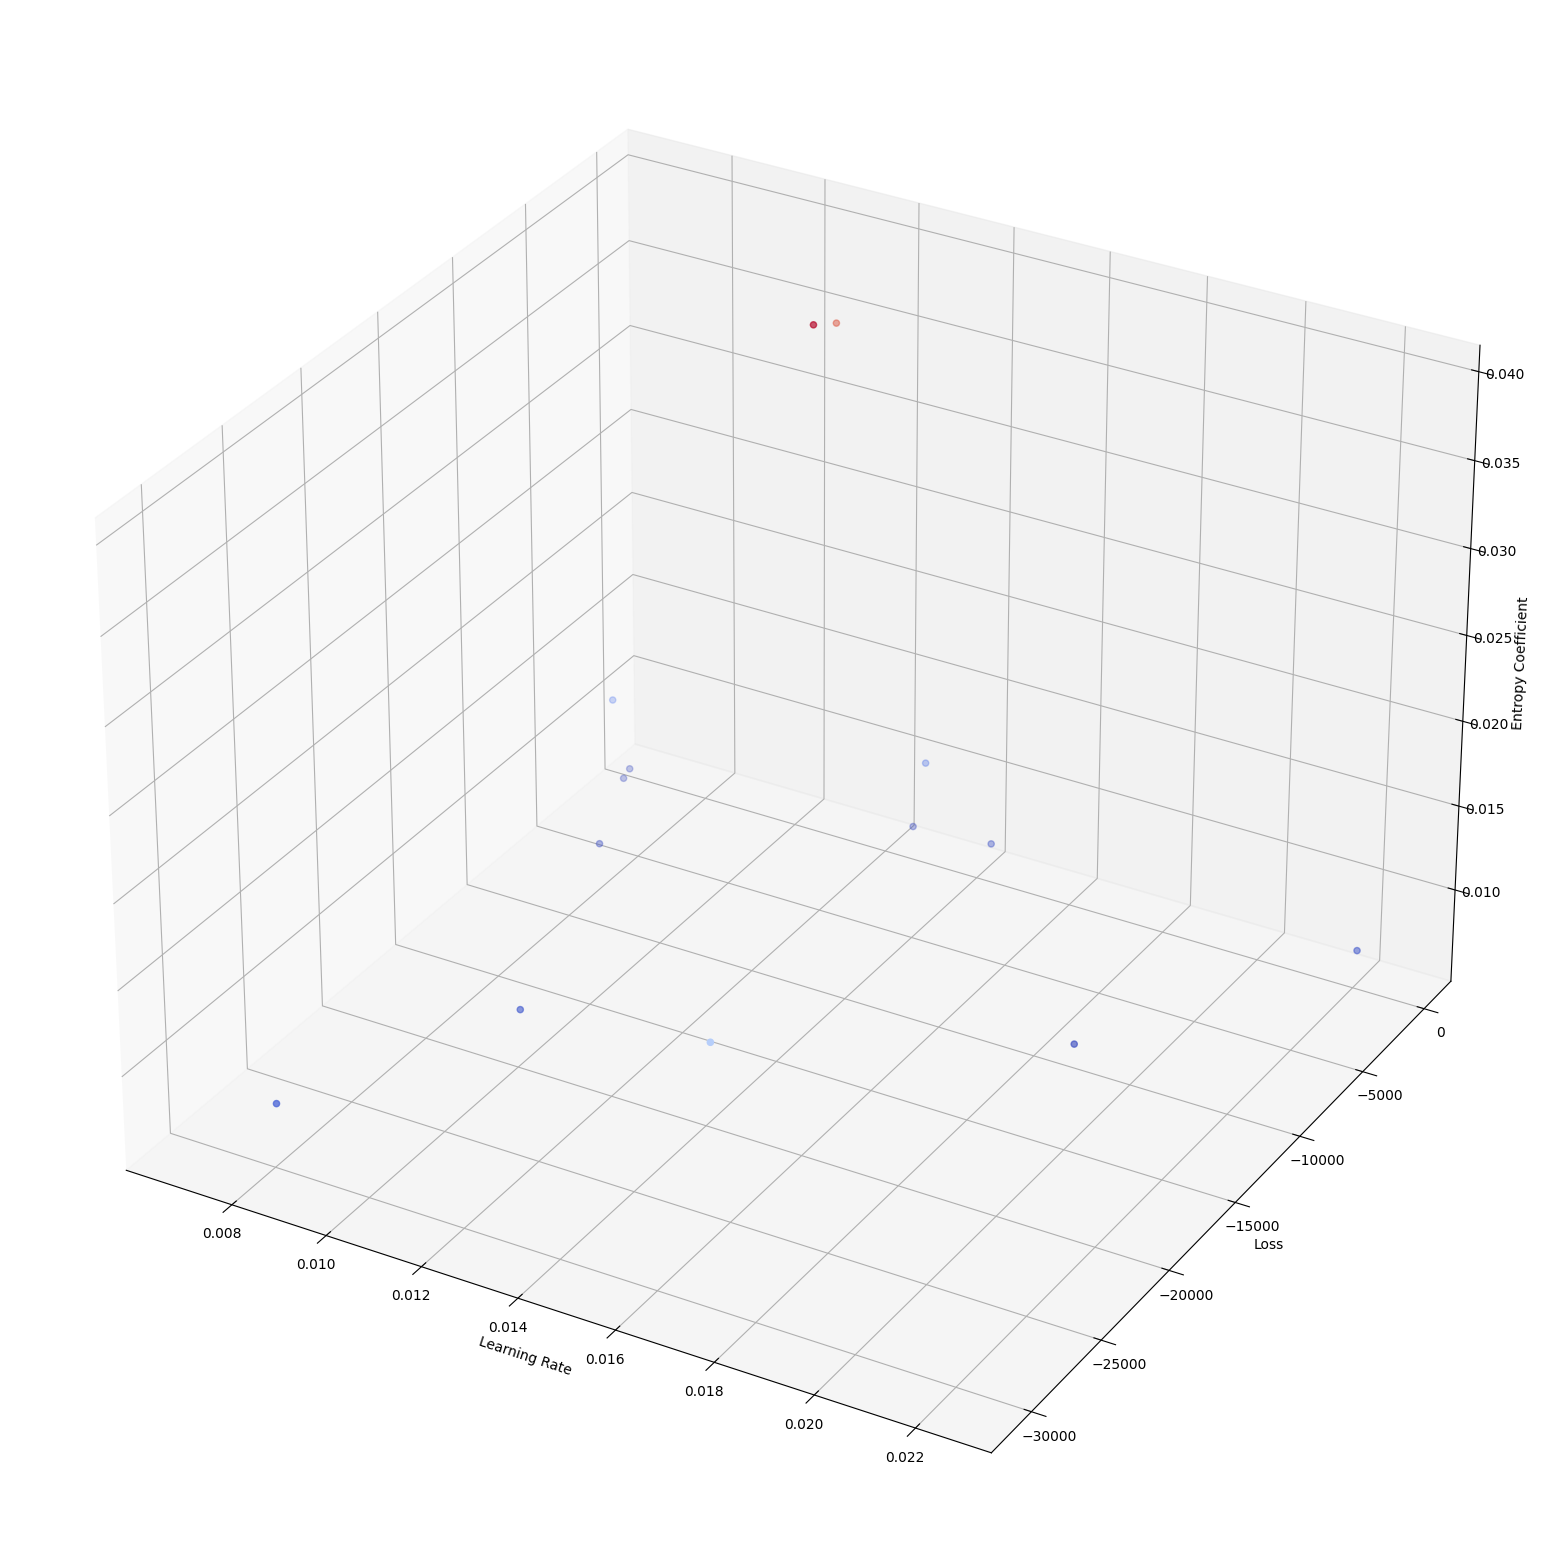

In [29]:
# generate a 3d plot of the learning rate, ent_coef, and loss
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

results_df_success_negative_low_entropy = results_df_success_negative[results_df_success_negative['ent_coef'] <= 0.2]

x = results_df_success_negative_low_entropy['learning_rate']
y = results_df_success_negative_low_entropy['loss']
z = results_df_success_negative_low_entropy['ent_coef']

ax.scatter(x, y, z, c=z, cmap=cm.coolwarm)

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Loss')
ax.set_zlabel('Entropy Coefficient')



# increase the plot size
fig.set_size_inches(20, 20)

plt.show()


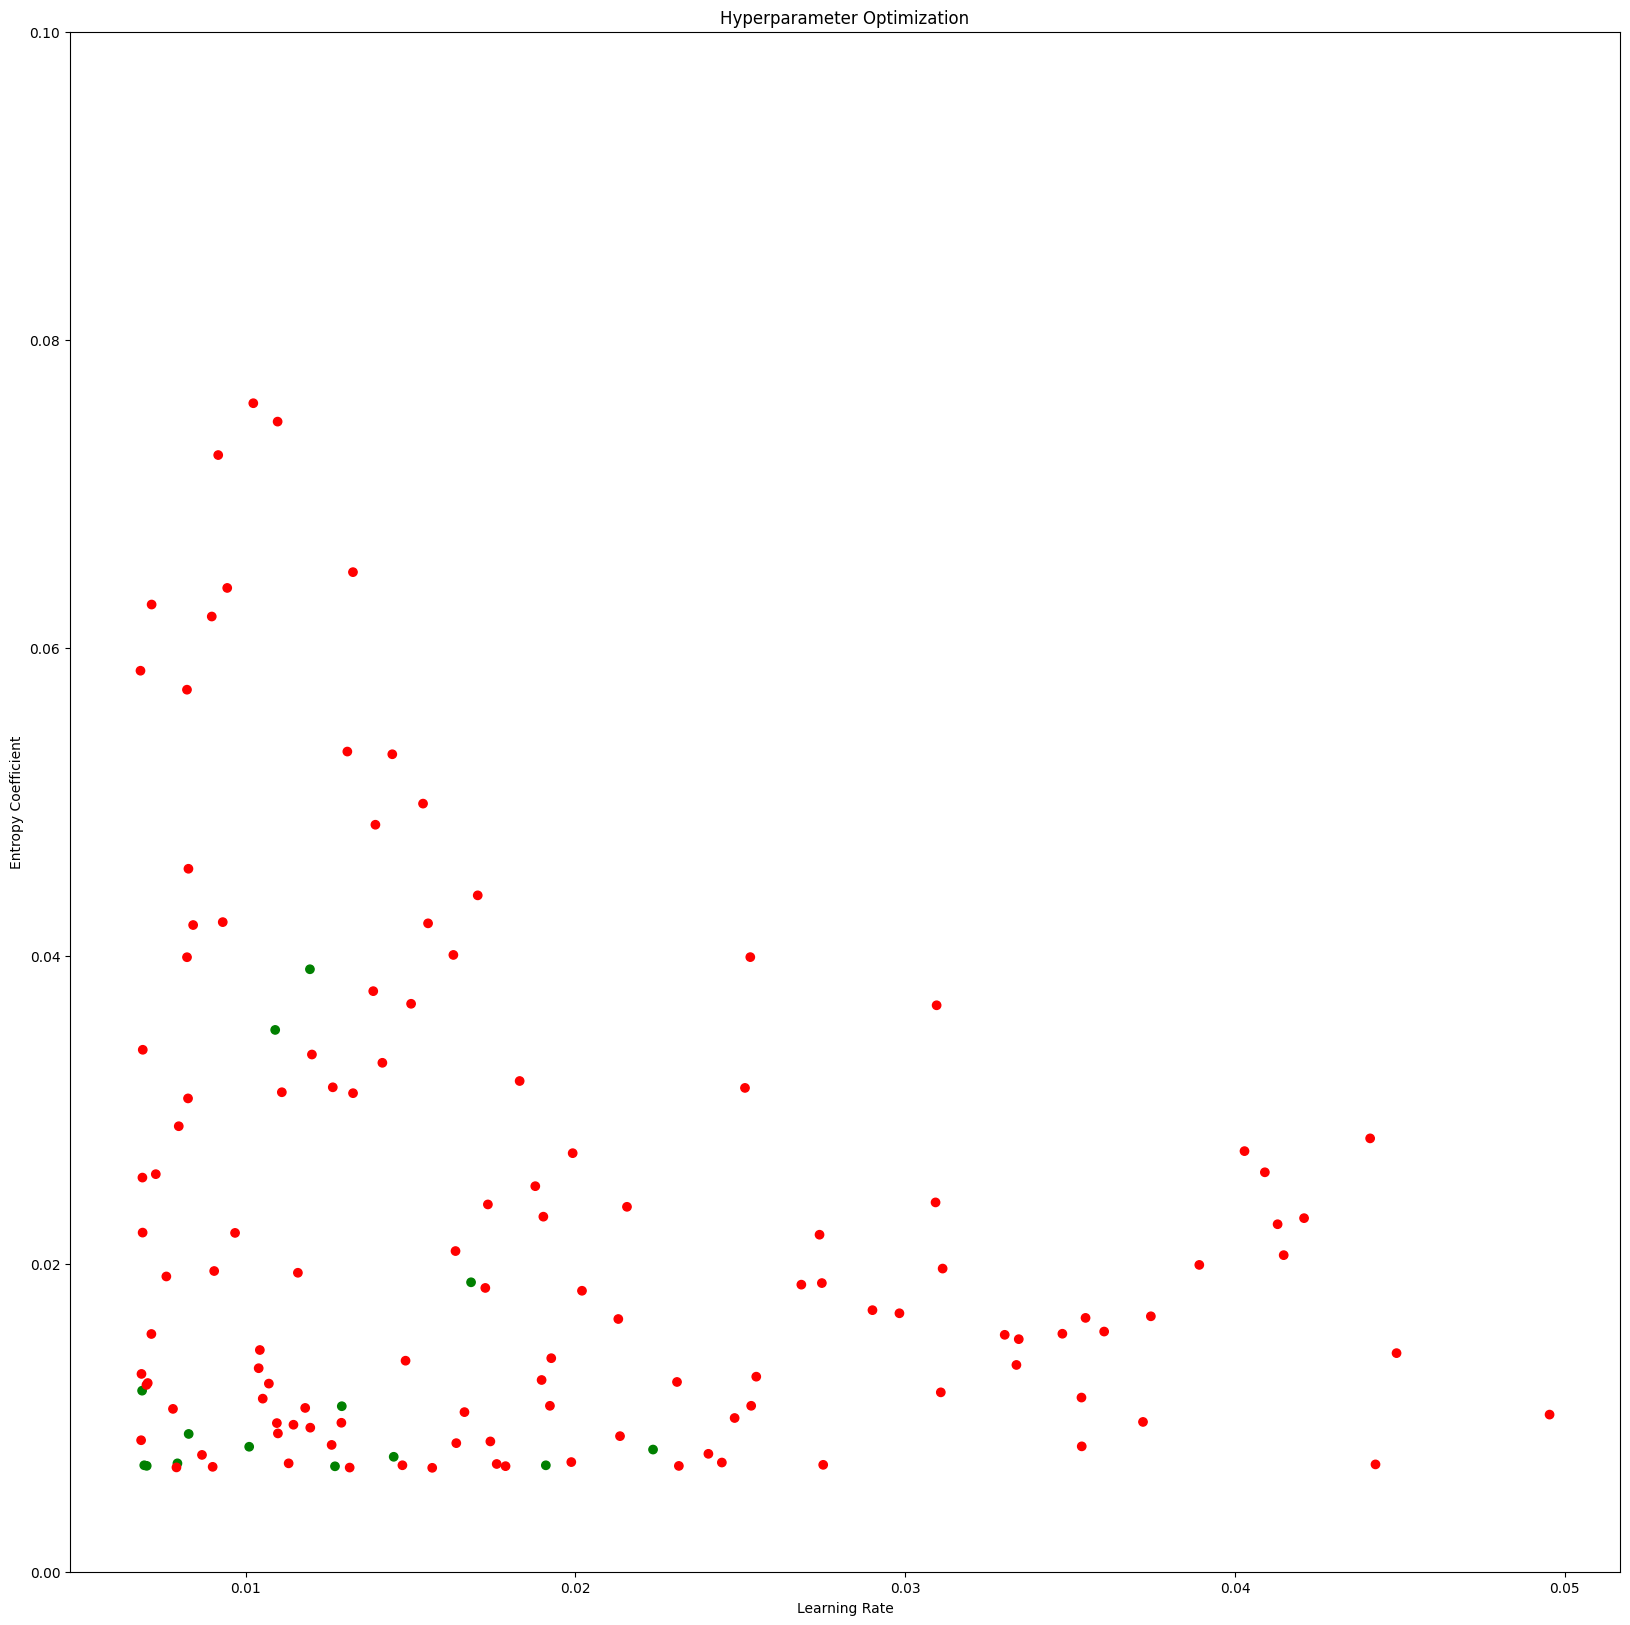

In [30]:
# visualize the parameters that cause failures in the objective function

# create a graph that has learning rate on the x-axis and ent_coef on the y-axis, 
# then the color of the points is whether the status is ok or fail, green for ok and red for fail

fig, ax = plt.subplots()
scatter = ax.scatter(results_df_success['learning_rate'], results_df_success['ent_coef'], 
                     c=results_df_success['loss'].apply(lambda x: 'green' if x < 0 else 'red'))
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Entropy Coefficient')
ax.set_title('Hyperparameter Optimization')
# plt.legend(handles=scatter.legend_elements()[0], labels=['OK', 'Fail'])
plt.ylim(0, 0.1)
# increase the plot size
fig.set_size_inches(20, 20)
plt.show()


In [ ]:

# create a heatmap with learning rate on the x-axis and ent_coef on the y-axis and the color is the loss
fig, ax = plt.subplots()
scatter = ax.scatter(results_df_success['learning_rate'], results_df_success['ent_coef'], 
                     c=results_df_success['loss'], cmap='viridis')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Entropy Coefficient')
ax.set_title('Hyperparameter Optimization')

plt.colorbar(scatter)
plt.ylim(0, 0.1)
# increase the plot size
fig.set_size_inches(25, 15)
plt.show()


In [ ]:
results_df_success_low_entropy = results_df_success[results_df_success['ent_coef'] <= 0.2]
# create a heatmap with learning rate on the x-axis and ent_coef on the y-axis and the color is the loss
fig, ax = plt.subplots()
scatter = ax.scatter(results_df_success_low_entropy['learning_rate'], results_df_success_low_entropy['loss'], 
                     c=results_df_success_low_entropy['ent_coef'], cmap=cm.coolwarm)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Loss')
ax.set_title('Hyperparameter Optimization')

plt.colorbar(scatter)
# plt.ylim(-50_000, 50_000)
# increase the plot size
fig.set_size_inches(25, 15)
plt.show()


In [ ]:
results_df_success_low_entropy = results_df_success[results_df_success['ent_coef'] <= 0.2]
# create a heatmap with learning rate on the x-axis and ent_coef on the y-axis and the color is the loss
fig, ax = plt.subplots()
scatter = ax.scatter(results_df_success_low_entropy['ent_coef'], results_df_success_low_entropy['loss'], 
                     c=results_df_success_low_entropy['learning_rate'], cmap=cm.coolwarm)
ax.set_xlabel('Entropy Coefficient')
ax.set_ylabel('Loss')
ax.set_title('Hyperparameter Optimization')

plt.colorbar(scatter)
# plt.ylim(-50_000, 50_000)
# increase the plot size
fig.set_size_inches(25, 15)
plt.show()


### Plot Results

In [17]:
# # create a dataframe of the rewards
# rewards_df = pd.DataFrame({'rewards': rewards})
# # plot the rewards
# plt.figure(figsize=(10, 5))
# sns.lineplot(data=rewards_df)
# plt.title('Rewards')
# plt.xlabel('Episode')
# plt.ylabel('Reward')
# plt.legend()
# plt.show()


In [18]:
# # import the models from /models folder
# import os
# import glob
# # get the list of models
# model_list = glob.glob('models_4_17_24/*.pkl')
# # separate the strings of each model name on _ and get the last element of the string if the string of the model doesn't include 'initial' or 'updated'
# model_list_episode_nbr = [model.split('_')[-1] for model in model_list if 'initial' not in model and 'updated' not in model]
# model_list_episode_nbr = [int(model_name.split('.')[0]) for model_name in model_list_episode_nbr]
# max_episode = max(model_list_episode_nbr)
# # test the last set of 10 episodes
# init_episode = ((int(max_episode)/10) - 10)*10
# # print(max_episode, init_episode)
# models = []
# # test the last set of 10 episodes from init_episode to max_episode
# for nbr in range(int(init_episode), int(max_episode)+10, 10):
#     # set up the appropriate time_points for each of the models in the list
#     env_train.time_points = list(symbols[1]['EURUSD'].iloc[-int(training_length):-(int(testing_length)-int(nbr)), :].index)# make this -nbr not +nbr next time
#     obs_train, info_train = env_train.reset(seed=2024)
#     # find the model name that contains the nbr
#     model_name = [model for model in model_list if str(nbr) in model][0]
#     print(model_name)
#     # load the models into a list
#     models.append(PPO.load(model_name, env=env_train))

In [19]:
# sim_testing = gym_mtsim.MtSimulator(
#     unit='USD',
#     balance=200000.,
#     leverage=100.,
#     stop_out_level=0.2,
#     hedge=True,
#     symbols_filename=FOREX_DATA_PATH
# )

# env_testing = MtEnv(
#     original_simulator=sim_testing,
#     trading_symbols=['EURUSD'],
#     window_size = window_size_param,
#     time_points=list(testing_index_slice),
#     hold_threshold=0.1,
#     close_threshold=0.1,
#     fee=lambda symbol: {
#         # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#         'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#         # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#     }[symbol],
#     symbol_max_orders=2,
#     multiprocessing_processes=2
# )

In [20]:
# model_ppo = PPO.load(f'models_4_17_24\model_25K_5.pkl', env=env_train)

# obs_test, info_test = env_testing.reset(seed=2024)
# done_test = False
# while not done_test:
#     action, _states = model_ppo.predict(obs_test)
#     obs_test, reward_test, terminated_test, truncated_test, info_test = env_testing.step(action)
#     done_test = terminated_test or truncated_test
#     # total_reward += reward_test
#     if done_test:
#         break
# try:
#     order_len = len(env_testing.render()['orders'])
# except:
#     order_len = 0
# # print(f"Episode: {episode}, Reward: {total_reward:.3f}, # orders: {order_len}")


In [21]:
# # if model_dict is still a thing
# for timestep in timesteps_models_dict.keys():
#     models_dict = timesteps_models_dict[timestep]

#     for nbr in range(0, 10):
#         msg = f"{'-'*8} Testing Model {nbr} with {timestep} training timesteps {'-'*8}"
#         print(f"""{msg}\n{'-'*len(msg)}""")
#         reward_across_episodes = []
#         rewards_dict = {}
#         model_results_dict = {}
#         for episode in range(0, 10):   
#             total_reward = 0
#             done_test = False
#             model_ppo = models_dict[f'model_{nbr}']

#             obs_test, info_test = env_train.reset(seed=2024)
#             while not done_test:
#                 action, _states = model_ppo.predict(obs_test)
#                 obs_test, reward_test, terminated_test, truncated_test, info_test = env_train.step(action)
#                 done_test = terminated_test or truncated_test
#                 total_reward += reward_test
#                 if done_test:
#                     break
#             reward_across_episodes.append(total_reward)
#             try:
#                 order_len = len(env_train.render()['orders'])
#             except:
#                 order_len = 0
#             print(f"Episode: {episode}, Reward: {total_reward:.3f}, # orders: {order_len}")
#         print_stats(reward_across_episodes)
#         model_results_dict[f'model_{nbr}_{timestep}'] = reward_across_episodes
# model_results_df = pd.DataFrame(model_results_dict)

In [22]:
# # plot the rewards for each model over episodes
# plt.figure(figsize=(10, 5))
# sns.lineplot(data=model_results_df)
# plt.title('Rewards')
# plt.xlabel('Episode')
# plt.ylabel('Reward')
# plt.legend()
# plt.show()

In [23]:
# # if model_dict is still a thing
# for timestep in ['25K']:
#     for nbr in tqdm(range(1, 10)):
#         msg = f"{'-'*8} Testing Model {nbr} with {timestep} training timesteps {'-'*8}"
#         print(f"""{msg}\n{'-'*len(msg)}""")
#         reward_across_episodes = []
#         number_of_orders_across_episodes = []
#         rewards_dict = {}
#         model_results_dict = {}
#         for episode in tqdm(range(0, 10)):   
#             total_reward = 0
#             done_test = False
#             model_ppo = PPO.load(f'models_4_17_24\model_{timestep}_{nbr}.pkl', env=env_train)

#             obs_test, info_test = env_testing.reset(seed=2024)
#             while not done_test:
#                 action, _states = model_ppo.predict(obs_test)
#                 obs_test, reward_test, terminated_test, truncated_test, info_test = env_testing.step(action)
#                 done_test = terminated_test or truncated_test
#                 total_reward += reward_test
#                 if done_test:
#                     break
#             reward_across_episodes.append(total_reward)
#             try:
#                 order_len = len(env_testing.render()['orders'])
#             except:
#                 order_len = 0
#             number_of_orders_across_episodes.append(order_len)
#             print(f"Episode: {episode}, Reward: {total_reward:.3f}, # orders: {order_len}")
#         print_stats(reward_across_episodes, 'Reward')
#         print_stats(number_of_orders_across_episodes, 'Orders')
#         model_results_dict[f'model_{nbr}_{timestep}'] = reward_across_episodes
# model_results_df = pd.DataFrame(model_results_dict)

In [24]:
# # plot the rewards for each model over episodes
# plt.figure(figsize=(10, 5))
# sns.lineplot(data=model_results_df)
# plt.title('Rewards')
# plt.xlabel('Episode')
# plt.ylabel('Reward')
# plt.legend()
# plt.show()

In [25]:
# # if the cluster has been restarted
# for nbr, time_points_idx in zip(range(0, 10), range(0, 500, 50)):
#     # model_ppo.learn(total_timesteps=25000, callback=ProgressBarCallback(100))
#     env_train = MtEnv(
#         original_simulator=sim_train,
#         trading_symbols=['EURUSD'],
#         window_size = window_size_param,
#         time_points=list(symbols[1]['EURUSD'].iloc[-int(training_length):-(int(testing_length)-int(time_points_idx)), :].index),
#         hold_threshold=0.5,
#         close_threshold=0.5,
#         fee=lambda symbol: {
#             # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#             'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#             # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#         }[symbol],
#         symbol_max_orders=2,
#         multiprocessing_processes=2
#     )
#     # obs_train, info_train = env_train.reset(seed=2024)
#     total_reward = 0
#     done_test = False
#     model_ppo = PPO.load(f'models\model_{nbr}.pkl', env=env_train)

#     env_testing = MtEnv(
#         original_simulator=sim_testing,
#         trading_symbols=['EURUSD'],
#         window_size = window_size_param,
#         # time_points=list(testing_index_slice),
#         hold_threshold=0.5,
#         close_threshold=0.5,
#         fee=lambda symbol: {
#             # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#             'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#             # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#         }[symbol],
#         symbol_max_orders=2,
#         multiprocessing_processes=2
#     )
#     obs_test, info_test = env_testing.reset(seed=2024)
#     while not done_test:
#         action, _states = model_ppo.predict(obs_test)
#         obs_test, reward_test, terminated_test, truncated_test, info_test = env_testing.step(action)
#         done_test = terminated_test or truncated_test
#         total_reward += reward_test
#         if done_test:
#             break
#     state = env_testing.render()

#     print(
#         f"balance: {state['balance']}, equity: {state['equity']}, margin: {state['margin']}\n"
#         f"free_margin: {state['free_margin']}, margin_level: {state['margin_level']}\n"

#     )
#     # print(state['orders'].Profit.sum())
#     if len(state['orders']) > 0:
#         print(state['orders'].Profit.sum())

In [26]:
# max_episode = 120
# for model_nbr in range(0, int(max_episode)+10, 10):
#     print(f'Model: {model_nbr}')
#     over_episodes_rewards = []
#     over_episodes_balance = []
#     obs_training, info_training = env_train.reset(seed=2024)
#     for episode in range(0, 10):
#         obs_test, info_test = env_testing.reset(seed=2024)
        
#         # model_ppo.learn(total_timesteps=25000, callback=ProgressBarCallback(100))

#         total_reward = 0
#         done_test = False
#         env_train.time_points = list(symbols[1]['EURUSD'].iloc[-int(training_length):-(int(testing_length)-int(model_nbr)), :].index)
#         obs_training, info_training = env_train.reset(seed=2024)
#         model_ppo = PPO.load(f'models\model_{model_nbr}.pkl', env=env_train)

#         while not done_test:
#             action, _states = model_ppo.predict(obs_test)
#             obs_test, reward_test, terminated_test, truncated_test, info_test = env_testing.step(action)
#             done_test = terminated_test or truncated_test

#             total_reward += reward_test
#             if done_test:
#                 break
#         over_episodes_balance.append(info_test['balance'])
#         over_episodes_rewards.append(total_reward)
#         print(f'Episode: {episode}, Reward: {total_reward:.3f}, Balance: {info_test["balance"]:.3f}')
#     print_stats(over_episodes_rewards)
#     print_stats(over_episodes_balance)

In [27]:
# data = pd.DataFrame(plot_data)

# sns.set_style('whitegrid')
# plt.figure(figsize=(8, 6))

# for key in plot_data:
#     if key == 'x':
#         continue
#     label = plot_settings[key]['label']
#     line = plt.plot('x', key, data=data, linewidth=1, label=label)

# plt.xlabel('episode')
# plt.ylabel('reward')
# plt.title('Random vs. SB3 Agents')
# plt.legend()
# plt.show()